In [1]:
import numpy as np 
import musclebeachtools as mbt
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy as cdc
import scipy.io as sio
import scipy
import datetime as dt
import plotly
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
import math
import sahara_work as saw
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.formula.api as smf
import neuraltoolkit as ntk
from scipy.stats import ks_2samp
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,v_measure_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import random
from random import choices
from matplotlib.collections import PolyCollection

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

from sys import platform
if platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'

from datetime import datetime

savedir = f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/'
today = datetime.today().strftime('%Y-%m-%d')

cmap = "YlGnBu"


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SAVEFIGS = 0

In [59]:
good_an = np.array(['caf100', 'caf101', 'caf102', 'caf103', 'caf104', 'caf106',
       'caf107', 'caf108', 'caf109', 'caf22', 'caf26', 'caf34', 'caf37',
       'caf40', 'caf42', 'caf49', 'caf50', 'caf52',
       'caf61', 'caf62', 'caf66', 'caf69', 'caf72', 'caf77', 'caf78',
       'caf79', 'caf80', 'caf81', 'caf82', 'caf84', 'caf88', 'caf89',
       'caf90', 'caf92', 'caf94', 'caf95', 'caf97', 'caf99',
       'eab40', 'eab47', 'eab50', 'kdr14', 'kdr27','kdr36','caf48', 'caf60'], dtype='<U6')

dfall_FR = pd.DataFrame()

for i in good_an:
    dftemp = []
    try:
        dftemp = pd.read_pickle(f'/{basedir}/HlabShare/james/FR_and_CV_pkls_2hr_v9_CV_filtered/' + i +'_fr.pkl').reset_index()
        dfall_FR = pd.concat([dfall_FR, dftemp], ignore_index=True)
    except:
        print('couldnt load pkl for ' + i)
        
dfall_FR.loc[(dfall_FR.peaklatency > .3), 'celltype'] = 'RSU'
dfall_FR.loc[(dfall_FR.peaklatency < .3), 'celltype'] = 'FS'
        
dfall_FR['age_days'] = dfall_FR.time/(24*3600)  
dfall_FR = dfall_FR[dfall_FR.fr < 50]
dfall_FR['logfr'] = np.log10(dfall_FR['fr'])

dfall_FR = dfall_FR.drop_duplicates(keep = 'last')

dfall_FR['bins'] = pd.cut(x=dfall_FR['age_days'], bins= [0,91,274,600],labels=['Young','Mid','Old'])


SW_FiringRates_df = pd.read_pickle('/media/HlabShare/james/FR_by_SW_2023-05-11.pkl')


In [80]:
print('mean FR of all principal neurons: ' + str(dfall_FR[(dfall_FR.peaklatency > 0.3) & (dfall_FR.fr < 5)].fr.mean()))
print('SEM of all principal neurons: ' + str(dfall_FR[(dfall_FR.peaklatency > 0.3) & (dfall_FR.fr < 5)].fr.std()/len(dfall_FR[(dfall_FR.peaklatency > 0.3) & (dfall_FR.fr < 5)].animal.unique())**0.5))


print('mean FR of all fs neurons: ' + str(dfall_FR[(dfall_FR.peaklatency < 0.3)].fr.mean()))
print('SEM of all fs neurons: ' + str(dfall_FR[(dfall_FR.peaklatency < 0.3)].fr.std()/len(dfall_FR[(dfall_FR.peaklatency < 0.3)].animal.unique())**0.5))

t, p = scipy.stats.ttest_ind(dfall_FR[(dfall_FR.peaklatency > 0.3) & (dfall_FR.fr < 5)].fr, 
                      dfall_FR[(dfall_FR.peaklatency < 0.3)].fr)
print('p = ' + str(p))



mean FR of all principal neurons: 2.0945892333984375
SEM of all principal neurons: 0.22030045061693346
mean FR of all fs neurons: 7.912286758422852
SEM of all fs neurons: 1.1856268176559368
p = 0.0


In [4]:
def set_phase(age):
    phase = 'C'
    if age < 75:
        phase = 'A'
    elif age < 300:
        phase = 'B'
    return phase

def get_real_age(start_time, birth, block_num, hour_bins=4):
    start_time = dt.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    birth = dt.datetime.strptime(birth, '%Y-%m-%d %H:%M:%S')
    age = start_time - birth
    age = age + dt.timedelta(hours = int((block_num * hour_bins)))
    age_in_days = age.days + (age.seconds / (60*60*24))
    return age_in_days

def clean_df(df):
    df['age'] = pd.to_timedelta(df['age'])
    df['age_days'] = df.apply(lambda x: x['age'].total_seconds()/60/60/24, axis=1)
    df['phase'] = df.apply(lambda x: set_phase(x['age_days']), axis=1)
    return df

def get_days_old(bday, current_day, time_frame, block_num, animal):
    if animal == 'eab47' or animal == 'eab' or animal == 'eab50':
        year = 2019
    elif animal == 'eab40':
        year = 2018
    else:
        year = 2020
    d1 = dt.date(year, int(current_day[0:2]), int(current_day[2:]))
    delta = d1-bday
    days = delta.days
    start_hour = int(time_frame[:time_frame.find('_')])
    num_diff = 4*int(block_num)
    time_of_day = start_hour+num_diff
    dec = time_of_day/24
    p = round(days+dec,2)
    return p

def get_error_points(start_age, ages):
    d_thresh = .17
    diff = np.diff(ages)
    dat = []
    if ages[0] - start_age > d_thresh:
        dat.append([start_age, ages[0]-start_age])
    for i, d in enumerate(diff):
        if d>d_thresh:
            dat.append([ages[i], d])
    return dat

def choose(animals, probe, thisan, thispr):
    if probe == -1:
        print(thisan, thispr)
    return (thisan in animals and thispr == probe)

def get_age_cat(geno, age):
    if geno == 'wt':
        cat = 'wt'
    else:
        if age <= 70:
            cat = 'early'
        elif age <= 100:
            cat = 'mid'
        elif age <=300:
            cat = 'late_mid'
        else:
            cat = 'late'
        cat = cat +'-'+geno
    return cat

def get_all_info(df, animal, window=7):
    d = df[df.apply(lambda x: choose(animal, s.get_probe(x['animal'], 'CA1'), x['animal'], x['probe']), axis=1)].sort_values(by=['date','time_frame', 'block_num'], key = lambda col: col.astype(int))
    d['rolling_dcc'] = d['dcc'].rolling(window=window).mean()
    
    #only keeping this if i need to go back to mpl from seaborn
    dcc = d['rolling_dcc'].astype(float).to_numpy()
    p_b = d['p_val_b'].astype(float).to_numpy()
    p_t = d['p_val_t'].astype(float).to_numpy()
    colors = ['slateblue' if (a>0.05 and b>0.05) else 'red' for a, b in zip(p_b, p_t)]
    ages = d['age'].astype(float).to_numpy()
    k2b = d['k2b'].rolling(window=window).mean().astype(float).to_numpy()
    k2t = d['k2t'].rolling(window=window).mean().astype(float).to_numpy()
    
    return d, dcc, colors, ages, [k2b, k2t]

def get_info(df, animal, window = 6):
    df = clean_df(df)
    d = df[df.apply(lambda x: choose(animal, saw.get_probe(x['animal'], 'CA1'), x['animal'], x['probe']), axis=1)].sort_values(by=['date','time_frame', 'block_num'], key = lambda col: col.astype(int))
    d['rolling_dcc'] = df.groupby(['animal'])['dcc'].transform(lambda x: x.rolling(window, 1).mean())
    return d


def get_fr_info(df, animals):
    d = df[df.apply(lambda x: choose(animals, 1, x['animal'], 1), axis=1)].sort_values(by=['days_old', 'cell_idx'], key = lambda col: col.astype(int))
    return d

def LNOCV(df,group_col='animal',X='fr',y='geno',N=1,max_splits=None):
    from itertools import combinations
    left_outs = list(combinations(set(df[group_col]), N))
    np.random.shuffle(left_outs)
    f1s,vms,cms = [],[],[]
    if max_splits is not None:
        left_outs = left_outs[:max_splits]
    left_outs = [list(lo) for lo in left_outs]
    for left_out in left_outs:
        test_df = df[df[group_col].isin(left_out)]
        train_df = df[~df[group_col].isin(left_out)]
        print(set(train_df[group_col]),set(test_df[group_col]))
        logreg = LogisticRegression(class_weight='balanced')
        logreg.fit(train_df[X].to_numpy().reshape(-1, 1),train_df[y].to_numpy().reshape(-1, 1))
        y_pred = logreg.predict(test_df[X].to_numpy().reshape(-1, 1))
        y_test = np.ndarray.flatten(test_df[y].to_numpy().reshape(-1, 1))
        f1 = f1_score(y_test, y_pred, average='micro')
        f1s.append(f1)
        vm = v_measure_score(y_test, y_pred)
        vms.append(vm)
        cm = confusion_matrix(y_test, y_pred)#, normalize='true') #why is this erroring?
        cms.append(cm)
        print(left_out, f1, vm, cm)
    return left_outs, f1s, vms, cms

def LNOCV_classwise(df,animal_col='animal',X='fr',y='geno',max_splits=None):
    from itertools import product
    f1s,vms,cms = [],[],[]
    group_mems_lol = []
    for genotype in set(df[y]): #select all pairs of [wt/e4,te4] and put in list
        group_mems = list(set(df[df[y]==genotype][animal_col]))
        group_mems_lol.append(group_mems)
    left_outs = [list(p) for p in product(*group_mems_lol)]
    np.random.shuffle(left_outs) #shuffle list of pairs
    if max_splits is not None: #if you only want to test on some (max_split) number of pairs
        left_outs = left_outs[:max_splits]
    for left_out in left_outs: #for left-out (test set) pair
        test_df = df[df[animal_col].isin(left_out)] #left-out as test set
        train_df = df[~df[animal_col].isin(left_out)] #every other animal as train set
        logreg = LogisticRegression(class_weight='balanced',solver='lbfgs') #creates a logistic regression model object
        logreg.fit(train_df[X].to_numpy().reshape(-1, 1),train_df[y].to_numpy().reshape(-1, 1)) #train logreg
        y_pred = np.ndarray.flatten(logreg.predict(test_df[X].to_numpy().reshape(-1, 1))) #predit genotype on test set
        y_test = np.ndarray.flatten(test_df[y].to_numpy().reshape(-1, 1)) #actual genotypes of test set
        f1 = f1_score(y_test, y_pred, average='micro')
        f1s.append(f1)
        vm = v_measure_score(y_test, y_pred)
        vms.append(vm)
        cm = confusion_matrix(y_test, y_pred)#, normalize='true') #why is this erroring?
        cms.append(cm)
        print(left_out, f1, vm, cm)
    return left_outs, f1s, vms, cms


def make_combined_fr_plot(df_FR, today, basedir, celltypestring, SAVEFIGS):

    ymin = 0.05
    start_age = np.min(df_FR.age_days)
    age_days_bins = []
    age_days_bins = np.arange(start_age,start_age+14.1,1/6)
    df_FR = df_FR.assign(age_days_bins=pd.cut(x=df_FR['age_days'], bins= age_days_bins).values)
    
    whichcolor = []
    if df_FR.iloc[0].geno == 'wt':
        whichcolor = sns.xkcd_rgb['gunmetal']
    elif df_FR.iloc[0].geno == 'te4':
        whichcolor = sns.xkcd_rgb['saffron']
    else:
        print('issue with genotype')
        
    fr_means = []
    fr_sems = []

    for a in np.arange(0,len(age_days_bins)-1):
        tempdf = df_FR[(df_FR.age_days > age_days_bins[a]) & (df_FR.age_days < age_days_bins[a+1])]
        if len(tempdf) > 0:
            fr_means.append(np.mean(tempdf.fr))
            fr_sems.append(np.std(tempdf.fr)/(len(tempdf.fr)**0.5)) 
        else:
            fr_means.append(np.nan)
            fr_sems.append(np.nan)

    if celltypestring == 'ensemble':
        if strip:
            sns.stripplot(y='fr',x='age_days_bins', data =df_FR[(df_FR.age_days > start_age) & (df_FR.age_days < start_age+14.1)], ax=ax, 
                          alpha=.3, s=1, color = whichcolor)
        # plot all single units:
        ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means, yerr=fr_sems, fmt="o", ms=2, 
                    color = whichcolor, linewidth=.5, zorder=3)
        # plot principal neurons
    elif celltypestring == 'just_RSU':
        for g in np.arange(3,len(age_days_bins[:-1]),6):
            ax.add_patch(patches.Rectangle((g, ymin),3,50,edgecolor = 'none',facecolor = 'grey',fill=True,alpha = 0.1))
        
        ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means, yerr=fr_sems, fmt='x', ms=3, 
                    color = whichcolor, linewidth=.5, zorder=3, label='RSU')
        # plot the FS cells
    elif celltypestring == 'just_FS':
        ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means, yerr=fr_sems, fmt='s', ms=2, 
                    ecolor = whichcolor, color = 'white', elinewidth = 0.75, mec = whichcolor, linewidth=.5, zorder=3, label='FS')


# Make plot of ensemble, just RSU, and just FS firing rates for example young WT:

In [5]:
#df_FR_young_wt = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/kdr27_fr.pkl').reset_index()
which_wt_animal = 'kdr36'

df_FR_young_wt = dfall_FR[dfall_FR.animal == which_wt_animal]
df_FR_young_wt.sort_values(by='age_days')


,index,fr,cellid,celltype,peaklatency,time,animal,cellqual,cellcount,geno,age_days,logfr,bins
244844,0,10.455139,2,RSU,0.72,7110410,kdr36,2,0,wt,82.296412,1.019330,Young
244936,92,4.315000,87,RSU,0.72,7110410,kdr36,2,37,wt,82.296412,0.634981,Young
244934,90,0.689306,83,RSU,0.64,7110410,kdr36,1,36,wt,82.296412,-0.161588,Young
244932,88,0.444861,76,RSU,0.56,7110410,kdr36,1,35,wt,82.296412,-0.351776,Young
244930,86,0.465139,68,RSU,0.52,7110410,kdr36,1,34,wt,82.296412,-0.332417,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258778,13934,10.956805,163,RSU,0.40,13270061,kdr36,2,7791,wt,153.588669,1.039684,Mid
258779,13935,24.036112,180,FS,0.24,13270061,kdr36,2,7792,wt,153.588669,1.380864,Mid
258780,13936,3.851111,203,RSU,0.52,13270061,kdr36,2,7793,wt,153.588669,0.585586,Mid
258770,13926,19.453611,53,FS,0.28,13270061,kdr36,1,7783,wt,153.588669,1.289000,Mid


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


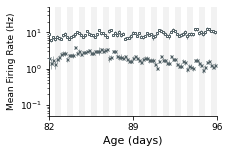

In [6]:
fig,ax = plt.subplots(figsize=[3,2])
strip = 0

#FR_df_example = df_FR_young_wt
#celltypestring = 'ensemble'
#make_combined_fr_plot_wt(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_young_wt[(df_FR_young_wt.cellqual <3) & (df_FR_young_wt.celltype == 'RSU') & (df_FR_young_wt.fr < 5)]
FR_df_example = FR_df_example.sort_values(by='age_days')
celltypestring = 'just_RSU'
make_combined_fr_plot(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_young_wt[(df_FR_young_wt.cellqual <3) & (df_FR_young_wt.celltype == 'FS')]
FR_df_example = FR_df_example.sort_values(by='age_days')
celltypestring = 'just_FS'
make_combined_fr_plot(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

plt.xlabel('Age (days)', fontsize=11)
plt.ylabel('Mean Firing Rate (Hz)', fontsize=9)
starting_age = round(np.min(df_FR_young_wt.age_days))
plt.xticks([0,7*6,14*6],[str(starting_age),str(starting_age+7),str(starting_age+14)], fontsize = 9)
plt.yticks([10, 1, .1], ['10${^1}$', '10$^{0}$', '10$^{-1}$'], fontsize = 9)
plt.ylim([0.05, 50])
plt.xlim([0, 84])
plt.yscale("log")

sns.despine(ax=ax)

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_{which_wt_animal}_mean_FR_all_celltypes_onefigure.pdf')


    
    

# Now do the same thing but for an example old TE4:

In [7]:
which_te4_animal = 'caf80'

df_FR_old_te4 = dfall_FR[dfall_FR.animal == which_te4_animal]
df_FR_old_te4.sort_values(by='age_days')
df_FR_old_te4 = df_FR_old_te4[df_FR_old_te4.age_days > 305.79]
df_FR_old_te4 = df_FR_old_te4[df_FR_old_te4.age_days < 305.8+14.11]


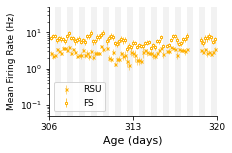

In [8]:
fig,ax = plt.subplots(figsize=[3,2])
strip = 0
# FR_df_example = df_FR_old_te4
# celltypestring = 'ensemble'
# make_combined_fr_plot_te4(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_old_te4[(df_FR_old_te4.cellqual <3) & (df_FR_old_te4.celltype == 'RSU') & (df_FR_old_te4.fr < 5)]
FR_df_example = FR_df_example.sort_values(by='age_days')
celltypestring = 'just_RSU'
make_combined_fr_plot(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_old_te4[(df_FR_old_te4.cellqual <3) & (df_FR_old_te4.celltype == 'FS')]
FR_df_example = FR_df_example.sort_values(by='age_days')
celltypestring = 'just_FS'
make_combined_fr_plot(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

plt.xlabel('Age (days)', fontsize=11)
plt.ylabel('Mean Firing Rate (Hz)', fontsize=9)
starting_age = round(np.min(df_FR_old_te4.age_days))
plt.xticks([0,7*6,14*6],[str(starting_age),str(starting_age+7),str(starting_age+14)], fontsize = 9)
plt.yticks([10, 1, .1], ['10${^1}$', '10$^{0}$', '10$^{-1}$'], fontsize = 9)
plt.ylim([0.05, 50])
plt.xlim([0, 84])
plt.yscale("log")
sns.despine(ax=ax)
plt.legend(fontsize=9)

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_{which_te4_animal}_mean_FR_all_celltypes_onefigure.pdf')
    


# Make KDE plots for firing rate distributions for ensemble, RSU, and FS:

ensemble
just_RSU
just_FS


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


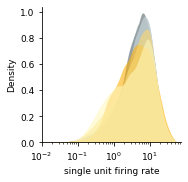

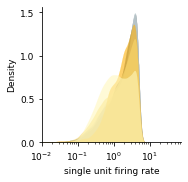

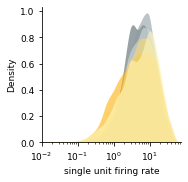

In [8]:
def plotKDE(df_, today, basedir, celltypestring, SAVEFIGS):

    fig, ax = plt.subplots(figsize=[2.5,2.5])
    print(celltypestring)

    p =['wt', 'te4']
    q = (['#cfdce1', '#8f9da2', '#536267'], ['#fff8bd', '#fbd86e', '#feb209'])
    r = zip(p,q)

    for gt in r:

        sns.kdeplot(data=df_[df_['geno']==gt[0]], x='fr', hue='bins', fill=True, common_norm=False,
            palette= gt[1], alpha=.6, linewidth=0.1, log_scale = True, ax = ax)

    ax.set_xlabel('single unit firing rate',fontsize=9 )
    ax.set_ylabel('Density', fontsize=9 )
    ax.set_xlim(0.01, 75)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    ax.get_legend().remove()

    sns.despine()

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_fr_kde_{celltypestring}.pdf')

SAVEFIGS = 0
df_ = []
df_ = dfall_FR
df_ = df_.replace('e4','wt')
celltypestring = 'ensemble'
plotKDE(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = []
df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.celltype == 'RSU') & (dfall_FR.fr <5)]
df_ = df_.replace('e4','wt')
celltypestring = 'just_RSU'
plotKDE(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = []
df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.celltype == 'FS')]
df_ = df_.replace('e4','wt')
celltypestring = 'just_FS'
plotKDE(df_, today, basedir, celltypestring, SAVEFIGS)


In [9]:
dfall_FR


,index,fr,cellid,celltype,peaklatency,time,animal,cellqual,cellcount,geno,age_days,logfr,bins
0,0,8.309167,18,FS,0.28,4952093,caf100,2,34,e4,57.315891,0.919558,Young
1,1,9.664444,18,FS,0.28,4959293,caf100,2,34,e4,57.399225,0.985177,Young
2,2,4.225139,22,RSU,0.48,4952093,caf100,2,35,e4,57.315891,0.625841,Young
3,3,6.041389,22,RSU,0.48,4959293,caf100,2,35,e4,57.399225,0.781137,Young
4,4,3.099306,30,RSU,0.68,4952093,caf100,2,36,e4,57.315891,0.491264,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293612,20797,0.697778,352,RSU,0.84,8136495,caf60,1,19118,te4,94.172396,-0.156283,Mid
293613,20798,1.257361,353,RSU,0.88,8136495,caf60,1,19119,te4,94.172396,0.099460,Mid
293614,20799,1.367083,357,RSU,0.72,8136495,caf60,1,19120,te4,94.172396,0.135795,Mid
293615,20800,0.676667,358,RSU,0.76,8136495,caf60,1,19121,te4,94.172396,-0.169625,Mid


# Or if you'd prefer to plot this data as boxens:

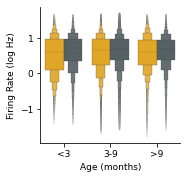

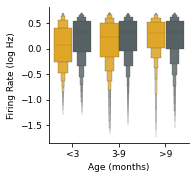

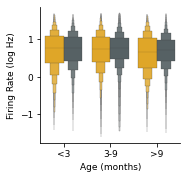

In [13]:
def plotboxen(df_, today, basedir, celltypestring, SAVEFIGS):
    
    plt.figure(figsize=[2.5,2.5])
    col_palette = [sns.xkcd_rgb['saffron'], sns.xkcd_rgb['gunmetal']]

    ax = sns.boxenplot(x = 'bins', y = 'logfr', hue = 'geno', showfliers=False, palette = col_palette, data=df_, linewidth = 0.25)

    plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
    plt.xlabel('Age (months)', fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel('Firing Rate (log Hz)', fontsize=9)
    ax.get_legend().remove()

    sns.despine()

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_boxen_FRs_{celltypestring}.pdf')

#SAVEFIGS = 0
df_ = dfall_FR
df_ = df_.replace('e4','wt')
df_ = df_.sort_values(by = 'geno')
celltypestring = 'ensemble'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.peaklatency > 0.3) & (dfall_FR.fr <5)]
df_ = df_.replace('e4','wt')
df_ = df_.sort_values(by = 'geno')
celltypestring = 'just_RSU'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.peaklatency < 0.3)]
df_ = df_.replace('e4','wt')
df_ = df_.sort_values(by = 'geno')
celltypestring = 'just_FS'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)


# And now if you'd like to ungroup WT and E4s:

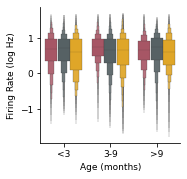

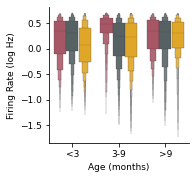

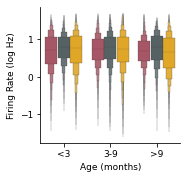

In [41]:
def plotboxen(df_, today, basedir, celltypestring, SAVEFIGS):
    
    plt.figure(figsize=[2.5,2.5])
    col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

    ax = sns.boxenplot(x = 'bins', y = 'logfr', hue = 'geno', showfliers=False, palette = col_palette, data=df_, linewidth = 0.25)

    plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
    plt.xlabel('Age (months)', fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel('Firing Rate (log Hz)', fontsize=9)
    ax.get_legend().remove()

    sns.despine()

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_boxen_FRs_{celltypestring}.pdf')

#SAVEFIGS = 1
df_ = dfall_FR
celltypestring = 'ensemble'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.peaklatency > 0.3) & (dfall_FR.fr <5)]
celltypestring = 'just_RSU'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.peaklatency < 0.3)]
celltypestring = 'just_FS'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

# Boxplots of firing rates by sleep/wake states for each geno:

In [5]:
# df_all = pd.read_pickle(f'/{basedir}/HlabShare/james_work/FR_by_SW_model_v4_20sec_min_bout.pkl')
# df_all.drop_duplicates()
# df_all = df_all.dropna()
# #df_all['geno'] = df_all['geno'].replace('e4', 'wt')

# # bins = [0, 90, 274, float('inf')]  
# # labels = ['young', 'mid', 'old']
# # df_all['age_group'] = pd.cut(df_all['age_days'], bins=bins, labels=labels, right=False)
# df_all = df_all[df_all.presence_ratio > .99]


/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1202358680.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_bin'] = pd.cut(filtered_df['age_days'], bins=bin_edges, labels=labels)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


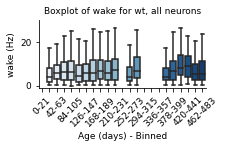

/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1202358680.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_bin'] = pd.cut(filtered_df['age_days'], bins=bin_edges, labels=labels)


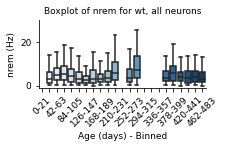

/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1202358680.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_bin'] = pd.cut(filtered_df['age_days'], bins=bin_edges, labels=labels)


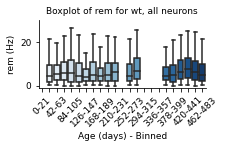

/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1202358680.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_bin'] = pd.cut(filtered_df['age_days'], bins=bin_edges, labels=labels)


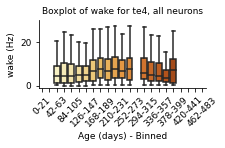

/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1202358680.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_bin'] = pd.cut(filtered_df['age_days'], bins=bin_edges, labels=labels)


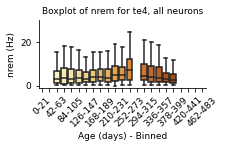

/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1202358680.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_bin'] = pd.cut(filtered_df['age_days'], bins=bin_edges, labels=labels)


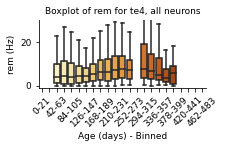

In [6]:
df_all = pd.read_pickle('/media/HlabShare/james_work/2023-08-01_FR_by_SW_model_v5_20sec_min_bout_melted.pkl')
df_all = df_all.drop_duplicates()
df_all = df_all.dropna()
df_all['geno'] = df_all['geno'].replace('e4', 'wt')

bins = [0, 90, 274, float('inf')]  
labels = ['young', 'mid', 'old']
df_all['age_group'] = pd.cut(df_all['age_days'], bins=bins, labels=labels, right=False)
df_all = df_all[df_all.presence_ratio > .99]


def make_mean_fr_plot(which_state, which_geno, which_cell_type):
    #Create bins for age_days
    
    dayz_binz = 21
    bin_edges = np.arange(0, 550, dayz_binz)
    labels = ['{}-{}'.format(edge, edge + dayz_binz) for edge in bin_edges[:-1]]

    #df_all Filter the dataframe for geno and cell type
    if which_cell_type == 'all':
        filtered_df = df_all[(df_all['geno'] == which_geno)]
    elif which_cell_type == 'principal':
        filtered_df = df_all[(df_all['geno'] == which_geno) & (df_all['cell_type'] == 'principal')]
    elif which_cell_type == 'fs':
        filtered_df = df_all[(df_all['geno'] == which_geno) & (df_all['cell_type'] == 'fs')]
    
    # Bin the age_days into intervals
    filtered_df['age_bin'] = pd.cut(filtered_df['age_days'], bins=bin_edges, labels=labels)

    # Create the boxplot
    
    if which_geno == 'wt':
        use_this_palette = 'Blues'
    elif which_geno == 'te4':
        use_this_palette = 'YlOrBr'
        
    plt.figure(figsize=[3.5,1.5])

    #which_state = 'wake'  # Change this to 'nrem' or 'rem' as needed
    filtered_state_df = filtered_df[filtered_df['state'] == which_state]
    sns.boxplot(x="age_bin", y="firing_rates", data=filtered_state_df, palette=use_this_palette, showfliers=False)
    
    # sns.boxplot(x="age_bin", y=which_state, data=filtered_df, palette = use_this_palette, showfliers=False)

    # Add labels and title to the plot
    plt.xlabel("Age (days) - Binned", fontsize=9)
    plt.ylabel(f"{which_state} (Hz)", fontsize=9)
    plt.yticks(fontsize=9)
    plt.title(f"Boxplot of {which_state} for {which_geno}, {which_cell_type} neurons", fontsize=9)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)
    # Get the current tick labels
    tick_labels = plt.gca().get_xticklabels()

    # Iterate over the tick labels and modify their visibility
    for i, label in enumerate(tick_labels):
        if i % 2 != 0:  # Skip every other label
            label.set_visible(False)

    # Update the tick labels
    plt.gca().set_xticklabels(tick_labels, fontsize=9)
    
    
    if which_cell_type == 'all':
        plt.ylim([-1,45])
    elif which_cell_type == 'principal':
        plt.ylim([-1,10])
    elif which_cell_type == 'fs':
        plt.ylim([-1,60])
        
    sns.despine()
    
    plt.savefig(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_SW_FR_{which_geno}_{which_cell_type}_{which_state}.pdf')
    # Display the plot
    plt.show()

    return filtered_df

which_cell_type = 'fs' # all, principal, or fs

for which_state in ['wake', 'nrem', 'rem']:
    which_geno = 'wt'
    filtered_df = make_mean_fr_plot(which_state, which_geno, which_cell_type)
      
for which_state in ['wake', 'nrem', 'rem']:
    which_geno = 'te4'
    filtered_df = make_mean_fr_plot(which_state, which_geno, which_cell_type)




# LME on FR by SW data:

In [5]:
# df_all = pd.read_pickle(f'/{basedir}/HlabShare/james_work/FR_by_SW_model_v4_20sec_min_bout.pkl')
# df_all = df_all.drop_duplicates()
# df_all = df_all.dropna()
# #df_all['geno'] = df_all['geno'].replace('e4', 'wt')

# # bins = [0, 90, 274, float('inf')]  
# # labels = ['young', 'mid', 'old']
# # df_all['age_group'] = pd.cut(df_all['age_days'], bins=bins, labels=labels, right=False)
# df_all = df_all[df_all.presence_ratio > .99]
# df_all

df_all = pd.read_pickle('/media/HlabShare/james_work/2023-08-01_FR_by_SW_model_v5_20sec_min_bout_melted.pkl')
df_all = df_all.drop_duplicates()
df_all = df_all.dropna()
df_all['geno'] = df_all['geno'].replace('e4', 'wt')

bins = [0, 90, 274, float('inf')]  
labels = ['young', 'mid', 'old']
df_all['age_group'] = pd.cut(df_all['age_days'], bins=bins, labels=labels, right=False)
df_all = df_all[df_all.presence_ratio > .99]

df_all


,pk_latency,overall_fr,presence_ratio,age_days,animal,cell_type,geno,neuron_number,age_group,state,firing_rates
0,0.96,4.032545,1.0,202.209306,CAF00042,principal,wt,0,mid,wake,5.782592
1,0.64,1.991666,1.0,202.209306,CAF00042,principal,wt,1,mid,wake,2.217408
2,0.60,4.453980,1.0,202.209306,CAF00042,principal,wt,2,mid,wake,6.049052
3,0.64,4.245253,1.0,202.209306,CAF00042,principal,wt,3,mid,wake,4.477872
4,0.84,4.222095,1.0,202.712789,CAF00042,principal,wt,4,mid,wake,4.676857
...,...,...,...,...,...,...,...,...,...,...,...
321613,0.64,9.611531,1.0,88.711100,CAF00100,other,wt,2884,young,rem,8.297468
321614,0.36,32.438170,1.0,88.711100,CAF00100,other,wt,2885,young,rem,26.887658
321615,0.72,10.767470,1.0,88.711100,CAF00100,other,wt,2886,young,rem,8.824367
321616,0.52,8.680168,1.0,88.711100,CAF00100,other,wt,2887,young,rem,5.773734


In [162]:
which_neuron_type = 'all' #'all', 'principal', or 'fs'
combine_e4_and_wt = 'yes' #'yes' or 'no'

df_stats = df_all
# df_stats = []
# if which_neuron_type == 'all':
#     df_stats = df_all #All neurons
# elif which_neuron_type == 'principal':
#     df_stats = df_all[(df_all['peaklatency'] > 0.3) & (df_all['fr'] < 5)] #Principal only
# elif which_neuron_type == 'fs':
#     df_stats = df_all[(df_all['peaklatency'] < 0.3)] #FS only
    
if combine_e4_and_wt == 'yes':
    df_stats['geno'] = df_stats['geno'].replace('e4', 'wt')

df_stats = df_stats.sort_values(by='geno', ascending=False)

if len(df_stats.geno.unique()) == 3:
    df_stats['geno'] = pd.Categorical(df_stats['geno'], categories=['wt', 'te4', 'e4'], ordered=False)
elif len(df_stats.geno.unique()) == 2:
    df_stats['geno'] = pd.Categorical(df_stats['geno'], categories=['wt', 'te4'], ordered=False)
    
df_stats['log_fr'] = np.log10(df_stats['firing_rates'])


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [163]:
df_stats = df_stats[np.isfinite(df_stats['log_fr'])]

In [7]:
df_stats.cell_type.unique()

array(['principal', 'other', 'fs'], dtype=object)

In [164]:
df_stats.to_csv(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/{today}_FR_by_SW_grouped_e4_wt.csv')

In [8]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [9]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-11_FR_by_SW_grouped_e4_wt.csv'
fr_data <- read_csv(file = fn)

# Input the desired cell type to filter
desired_cell_type <- "all" # options you can use: ['principal', 'fs', 'other', 'all]

# Filter the data based on the desired cell type
if (desired_cell_type == 'all') {
  filtered_data <- fr_data
} else {
  filtered_data <- fr_data[fr_data$cell_type == desired_cell_type, ]
}

# # Create a subset of the dataframe based on the cell type
# if (desired_cell_type %in% fr_data$cell_type) {
#   filtered_data <- fr_data[fr_data$cell_type == desired_cell_type, ]
# } else {
#   # Handle the case when the desired cell type is not found
#   filtered_data <- NULL  # or any other appropriate action
# }

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
fr_lmer = lmer(log_fr ~ age_days * geno * state * cell_type  + (1|animal), data = filtered_data)


RParsingError: Parsing status not OK - PARSING_STATUS.PARSE_ERROR

In [ ]:
%%R

fr_data

In [167]:
%%R 
# this will provide general information
summary(fr_lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_fr ~ age_days * geno * state * cell_type + (1 | animal)
   Data: filtered_data

REML criterion at convergence: 322536.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2890 -0.5431  0.0715  0.6713  3.6082 

Random effects:
 Groups   Name        Variance Std.Dev.
 animal   (Intercept) 0.00932  0.09654 
 Residual             0.15930  0.39912 
Number of obs: 321577, groups:  animal, 39

Fixed effects:
                                               Estimate Std. Error         df
(Intercept)                                   7.041e-01  3.101e-02  4.628e+01
age_days                                     -6.011e-04  5.260e-05  2.009e+05
genowt                                       -8.635e-02  3.765e-02  5.083e+01
staterem                                      7.665e-02  1.084e-02  3.215e+05
statewake                                     1.019e-01  1.084e-02  3.215e+05
cell_typeother 


Correlation matrix not shown by default, as p = 36 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it



In [170]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(fr_lmer)

Type III Analysis of Variance Table with Satterthwaite's method
                              Sum Sq Mean Sq NumDF  DenDF    F value    Pr(>F)
age_days                         0.1     0.1     1   6302     0.5474  0.459428
geno                             0.0     0.0     1     46     0.2669  0.607927
state                          132.6    66.3     2 321505   416.1980 < 2.2e-16
cell_type                     9670.1  4835.0     2 320934 30352.5614 < 2.2e-16
age_days:geno                    0.1     0.1     1   6302     0.7257  0.394317
age_days:state                  47.1    23.5     2 321505   147.7508 < 2.2e-16
geno:state                      26.4    13.2     2 321505    82.7617 < 2.2e-16
age_days:cell_type             212.0   106.0     2 320195   665.4054 < 2.2e-16
geno:cell_type                 116.3    58.2     2 320934   365.0747 < 2.2e-16
state:cell_type                163.0    40.8     4 321505   255.8342 < 2.2e-16
age_days:geno:state             31.1    15.6     2 321505    97.632

In [175]:
%%R
emmresults = emmeans(fr_lmer, pairwise ~  geno * cell_type * age_days, adjust = 'tukey')
print(emmresults)

$emmeans
 geno cell_type age_days emmean     SE  df asymp.LCL asymp.UCL
 te4  fs             172  0.699 0.0293 Inf     0.642     0.756
 wt   fs             172  0.715 0.0187 Inf     0.679     0.752
 te4  other          172  0.968 0.0293 Inf     0.911     1.026
 wt   other          172  0.953 0.0187 Inf     0.916     0.990
 te4  principal      172  0.166 0.0293 Inf     0.108     0.223
 wt   principal      172  0.197 0.0187 Inf     0.160     0.233

Results are averaged over the levels of: state 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$contrasts
 contrast                                                                      
 te4 fs age_days172.094013048859 - wt fs age_days172.094013048859              
 te4 fs age_days172.094013048859 - te4 other age_days172.094013048859          
 te4 fs age_days172.094013048859 - wt other age_days172.094013048859           
 te4 fs age_days172.094013048859 - te4 principal age_days172.094013048859      
 te4 fs age_days172.0

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 321577' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 321577)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 321577' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 321577)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 321577' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 321577)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 321577' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 321577)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


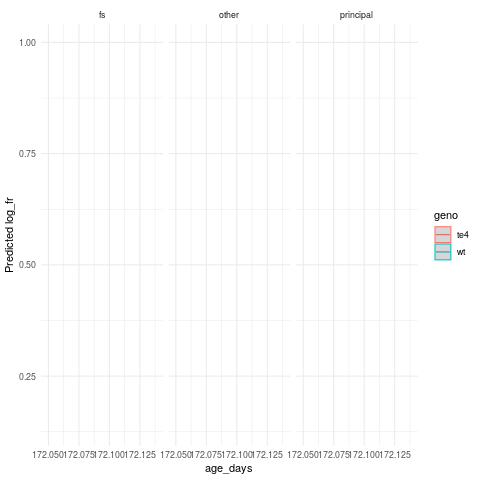

In [176]:
%%R
# emmresults = emmeans(fr_lmer, pairwise ~  geno | cell_type | age_days, adjust = 'tukey')
# print(emmresults)

emm_int = emmeans(fr_lmer, ~ geno*cell_type | age_days)
plot(emm_int, by = "cell_type", intervals = TRUE)
emm_df = as.data.frame(emm_int)

ggplot(emm_df, aes(x = age_days, y = emmean, color = geno, group = geno)) + 
  geom_line() + 
  geom_ribbon(aes(ymin = emmean - SE, ymax = emmean + SE), alpha = 0.2) +
  facet_wrap(~ cell_type) +
  theme_minimal() +
  labs(y = "Predicted log_fr")

In [124]:
%%R
emmeans(fr_lmer, list(pairwise ~  geno | state | age_group), adjust = 'tukey')

#emmeans(fr_lmer, list(pairwise ~  state | age_group * geno), adjust = 'tukey', pbkrtest.limit = 321618)

$`emmeans of geno | state, age_group`
state = nrem, age_group = mid:
 geno emmean    SE  df asymp.LCL asymp.UCL
 te4    2.05 0.271 Inf      1.52      2.58
 wt     1.99 0.168 Inf      1.66      2.32

state = rem, age_group = mid:
 geno emmean    SE  df asymp.LCL asymp.UCL
 te4    2.47 0.271 Inf      1.94      3.00
 wt     2.55 0.168 Inf      2.22      2.87

state = wake, age_group = mid:
 geno emmean    SE  df asymp.LCL asymp.UCL
 te4    2.54 0.271 Inf      2.01      3.08
 wt     2.88 0.168 Inf      2.55      3.21

state = nrem, age_group = old:
 geno emmean    SE  df asymp.LCL asymp.UCL
 te4    2.35 0.365 Inf      1.64      3.07
 wt     2.07 0.246 Inf      1.59      2.56

state = rem, age_group = old:
 geno emmean    SE  df asymp.LCL asymp.UCL
 te4    3.17 0.365 Inf      2.46      3.89
 wt     2.45 0.246 Inf      1.97      2.94

state = wake, age_group = old:
 geno emmean    SE  df asymp.LCL asymp.UCL
 te4    2.63 0.365 Inf      1.91      3.34
 wt     2.57 0.246 Inf      2.09      3.06

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 109293' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 109293)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 109293' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 109293)' or larger];
but be warned that this may result in large computation time and memory use.


In [112]:
%%R
emmeans(fr_lmer, list(pairwise ~  state), adjust = 'tukey')


$`emmeans of state`
 state emmean    SE  df asymp.LCL asymp.UCL
 nrem    2.18 0.129 Inf      1.92      2.43
 rem     2.59 0.129 Inf      2.34      2.85
 wake    2.64 0.129 Inf      2.39      2.89

Results are averaged over the levels of: age_group, geno 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$`pairwise differences of state`
 1           estimate     SE  df z.ratio p.value
 nrem - rem   -0.4171 0.0151 Inf -27.590  <.0001
 nrem - wake  -0.4630 0.0151 Inf -30.620  <.0001
 rem - wake   -0.0458 0.0151 Inf  -3.030  0.0069

Results are averaged over the levels of: age_group, geno 
Degrees-of-freedom method: asymptotic 
P value adjustment: tukey method for comparing a family of 3 estimates 



Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 109293' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 109293)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 109293' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 109293)' or larger];
but be warned that this may result in large computation time and memory use.
NOTE: Results may be misleading due to involvement in interactions


In [3]:
df_stats = pd.read_csv('/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-11_FR_by_SW_grouped_e4_wt.csv')



In [4]:
df_stats

,Unnamed: 0,pk_latency,overall_fr,presence_ratio,age_days,animal,cell_type,geno,neuron_number,age_group,state,firing_rates,log_fr
0,0,0.96,4.032545,1.0,202.209306,CAF00042,principal,wt,0,mid,wake,5.782592,0.762123
1,188656,0.36,16.284330,1.0,100.702500,KDR00036,other,wt,7595,mid,nrem,13.567661,1.132505
2,188644,0.60,6.435415,1.0,100.702500,KDR00036,other,wt,7583,mid,nrem,5.455084,0.736801
3,188645,0.80,12.723682,1.0,100.702500,KDR00036,other,wt,7584,mid,nrem,8.726109,0.940821
4,188646,0.84,8.639649,1.0,100.702500,KDR00036,other,wt,7585,mid,nrem,7.562118,0.878643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321572,56016,0.28,13.054527,1.0,203.108264,CAF00052,fs,te4,1353,mid,wake,18.700997,1.271865
321573,56017,0.28,0.287963,1.0,203.108264,CAF00052,fs,te4,1354,mid,wake,0.328442,-0.483541
321574,56018,0.12,0.228773,1.0,203.108264,CAF00052,fs,te4,1355,mid,wake,0.266507,-0.574292
321575,56019,0.12,4.992288,1.0,203.108264,CAF00052,fs,te4,1356,mid,wake,7.569601,0.879073


In [21]:
df_te4 = df_stats[(df_stats.age_days > 274) & (df_stats.state == 'rem') & (df_stats.geno == 'te4')]
df_wt = df_stats[(df_stats.age_days > 274) & (df_stats.state == 'rem') & (df_stats.geno != 'te4')]

arr_te4 = df_te4.groupby('animal').firing_rates.mean().values
arr_wt = df_wt.groupby('animal').firing_rates.mean().values
scipy.stats.ttest_ind(arr_te4, arr_wt)


Ttest_indResult(statistic=0.7652502309328325, pvalue=0.46022649088618306)

In [81]:
df_stats

,pk_latency,overall_fr,presence_ratio,age_days,animal,cell_type,geno,neuron_number,age_group,state,firing_rates
0,0.96,4.032545,1.0,202.209306,CAF00042,principal,wt,0,mid,wake,5.782592
188656,0.36,16.284330,1.0,100.702500,KDR00036,other,wt,7595,mid,nrem,13.567661
188644,0.60,6.435415,1.0,100.702500,KDR00036,other,wt,7583,mid,nrem,5.455084
188645,0.80,12.723682,1.0,100.702500,KDR00036,other,wt,7584,mid,nrem,8.726109
188646,0.84,8.639649,1.0,100.702500,KDR00036,other,wt,7585,mid,nrem,7.562118
...,...,...,...,...,...,...,...,...,...,...,...
56016,0.28,13.054527,1.0,203.108264,CAF00052,fs,te4,1353,mid,wake,18.700997
56017,0.28,0.287963,1.0,203.108264,CAF00052,fs,te4,1354,mid,wake,0.328442
56018,0.12,0.228773,1.0,203.108264,CAF00052,fs,te4,1355,mid,wake,0.266507
56019,0.12,4.992288,1.0,203.108264,CAF00052,fs,te4,1356,mid,wake,7.569601


In [92]:
df_stats[(df_stats.cell_type == 'fs') & (df_stats.state == 'nrem')].firing_rates

175933     1.137768
175921    15.128641
175922    15.557797
175923     3.805218
175924     3.386226
            ...    
162205     4.531965
162206     8.226615
162207     3.634253
162208     1.935061
162209     1.985700
Name: firing_rates, Length: 36644, dtype: float64

In [116]:
df_stats.animal.unique()

array(['CAF00042', 'KDR00036', 'CAF00089', 'KDR00014', 'CAF00026',
       'CAF00108', 'CAF00050', 'CAF00103', 'CAF00109', 'CAF00100',
       'KDR00027', 'CAF00077', 'CAF00081', 'CAF00090', 'CAF00101',
       'CAF00034', 'CAF00092', 'CAF00088', 'CAF00104', 'CAF00061',
       'CAF00102', 'CAF00097', 'CAF00095', 'CAF00040', 'CAF00094',
       'CAF00082', 'CAF00069', 'CAF00107', 'CAF00048', 'CAF00049',
       'CAF00060', 'CAF00084', 'CAF00022', 'CAF00072', 'CAF00078',
       'CAF00079', 'CAF00037', 'CAF00052', 'CAF00062'], dtype=object)

# Mean FR stats for table:

In [58]:
print('JUST PRINCIPAL NEURONS:')

for tmp_geno in ['wt', 'te4']:
    for tmp_age_group in ['young', 'mid', 'old']:
        for tmp_state in ['wake', 'nrem', 'rem']:
            print('Mean FR for ' + tmp_geno + ', ' + tmp_age_group + ', ' + tmp_state + ' : ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == tmp_age_group) & (df_stats.geno == tmp_geno) & (df_stats.state == tmp_state)].firing_rates.mean()))
            
print('')
print('')
print('JUST FS NEURONS:')

for tmp_geno in ['wt', 'te4']:
    for tmp_age_group in ['young', 'mid', 'old']:
        for tmp_state in ['wake', 'nrem', 'rem']:
            print('Mean FR for ' + tmp_geno + ', ' + tmp_age_group + ', ' + tmp_state + ' : ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == tmp_age_group) & (df_stats.geno == tmp_geno) & (df_stats.state == tmp_state)].firing_rates.mean()))
            
            
print('')
print('')
print('')

print('JUST PRINCIPAL NEURONS:')

for tmp_geno in ['wt', 'te4']:
    for tmp_age_group in ['young', 'mid', 'old']:
        for tmp_state in ['wake', 'nrem', 'rem']:
            print('SEM for ' + tmp_geno + ', ' + tmp_age_group + ', ' + tmp_state + ' : ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == tmp_age_group) & (df_stats.geno == tmp_geno) & (df_stats.state == tmp_state)].firing_rates.std()/(len(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == tmp_age_group) & (df_stats.geno == tmp_geno) & (df_stats.state == tmp_state)].animal.unique())**0.5)))
            
print('')
print('')
print('JUST FS NEURONS:')

for tmp_geno in ['wt', 'te4']:
    for tmp_age_group in ['young', 'mid', 'old']:
        for tmp_state in ['wake', 'nrem', 'rem']:
            print('SEM for ' + tmp_geno + ', ' + tmp_age_group + ', ' + tmp_state + ' : ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == tmp_age_group) & (df_stats.geno == tmp_geno) & (df_stats.state == tmp_state)].firing_rates.std()/(len(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == tmp_age_group) & (df_stats.geno == tmp_geno) & (df_stats.state == tmp_state)].animal.unique())**0.5)))
            
            
            
            
            

JUST PRINCIPAL NEURONS:
Mean FR for wt, young, wake : 2.5244280327094506
Mean FR for wt, young, nrem : 2.1270811384290753
Mean FR for wt, young, rem : 2.392955967044601
Mean FR for wt, mid, wake : 2.622756881578227
Mean FR for wt, mid, nrem : 1.7362398332052178
Mean FR for wt, mid, rem : 2.2891479139430606
Mean FR for wt, old, wake : 2.467707052446154
Mean FR for wt, old, nrem : 1.9669245264258832
Mean FR for wt, old, rem : 2.346936531882058
Mean FR for te4, young, wake : 1.6511910485359618
Mean FR for te4, young, nrem : 1.4280319529934298
Mean FR for te4, young, rem : 1.4938611850187624
Mean FR for te4, mid, wake : 2.250036010784896
Mean FR for te4, mid, nrem : 1.755292518654022
Mean FR for te4, mid, rem : 2.1733033586213204
Mean FR for te4, old, wake : 2.5388261796748686
Mean FR for te4, old, nrem : 2.2636559430964276
Mean FR for te4, old, rem : 3.083855980982105


JUST FS NEURONS:
Mean FR for wt, young, wake : 8.830778904692451
Mean FR for wt, young, nrem : 6.206942466471945
Mean FR

In [119]:
df_stats.age_days.max()

532.8782638888889

In [113]:
print('ALL NEURONS:')
print('')

print('WT FRs:')

print('young WT Wake FR: ' + str(df_stats[(df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('young WT NREM FR: ' + str(df_stats[(df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young WT REM FR: ' + str(df_stats[(df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid WT Wake FR: ' + str(df_stats[(df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid WT NREM FR: ' + str(df_stats[(df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid WT REM FR: ' + str(df_stats[(df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old WT Wake FR: ' + str(df_stats[(df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old WT NREM FR: ' + str(df_stats[(df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old WT REM FR: ' + str(df_stats[(df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('')
print('TE4 now:')

print('young TE4 Wake FR: ' + str(df_stats[(df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('young TE4 NREM FR: ' + str(df_stats[(df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young TE4 REM FR: ' + str(df_stats[(df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid TE4 Wake FR: ' + str(df_stats[(df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid TE4 NREM FR: ' + str(df_stats[(df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid TE4 REM FR: ' + str(df_stats[(df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old TE4 Wake FR: ' + str(df_stats[(df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old TE4 NREM FR: ' + str(df_stats[(df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old TE4 REM FR: ' + str(df_stats[(df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')



ALL NEURONS:

WT FRs:
young WT Wake FR: 7.485805896944107
young WT NREM FR: 5.83714166624074
young WT REM FR: 7.692500092649947

mid WT Wake FR: 7.7155332572454345
mid WT NREM FR: 5.381470575103905
mid WT REM FR: 7.561404461453621

old WT Wake FR: 6.683989452143205
old WT NREM FR: 5.3308045668907695
old WT REM FR: 6.911216714456597


TE4 now:
young TE4 Wake FR: 6.756297477710987
young TE4 NREM FR: 5.551453007450481
young TE4 REM FR: 7.487303370743433

mid TE4 Wake FR: 7.730615926743233
mid TE4 NREM FR: 5.616793042696654
mid TE4 REM FR: 8.174514991587907

old TE4 Wake FR: 7.206919737325807
old TE4 NREM FR: 6.363045078776785
old TE4 REM FR: 9.80615157134757



In [114]:
print('JUST PRINCIPAL NEURONS:')
print('')

print('WT FRs:')

print('young WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('young WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('')
print('TE4 now:')

print('young TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('young TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')



JUST PRINCIPAL NEURONS:

WT FRs:
young WT Wake FR: 2.5244280327094506
young WT NREM FR: 2.1270811384290753
young WT REM FR: 2.392955967044601

mid WT Wake FR: 2.622756881578227
mid WT NREM FR: 1.7362398332052178
mid WT REM FR: 2.2891479139430606

old WT Wake FR: 2.467707052446154
old WT NREM FR: 1.9669245264258832
old WT REM FR: 2.346936531882058


TE4 now:
young TE4 Wake FR: 1.6511910485359618
young TE4 NREM FR: 1.4280319529934298
young TE4 REM FR: 1.4938611850187624

mid TE4 Wake FR: 2.250036010784896
mid TE4 NREM FR: 1.755292518654022
mid TE4 REM FR: 2.1733033586213204

old TE4 Wake FR: 2.5388261796748686
old TE4 NREM FR: 2.2636559430964276
old TE4 REM FR: 3.083855980982105



In [41]:
print('JUST FS NEURONS:')
print('')

print('WT FRs:')

print('young WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('young WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('')
print('TE4 now:')

print('young TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('young TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'fs') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')



JUST FS NEURONS:

WT FRs:
young WT Wake FR: 8.830778904692451
young WT NREM FR: 6.206942466471945
young WT REM FR: 9.575107326396228

mid WT Wake FR: 9.452659764915794
mid WT NREM FR: 6.512969226643583
mid WT REM FR: 9.353700466241076

old WT Wake FR: 7.519799196232645
old WT NREM FR: 5.5789904188437145
old WT REM FR: 7.947316801804854


TE4 now:
young TE4 Wake FR: 9.11194980722887
young TE4 NREM FR: 7.648517303033545
young TE4 REM FR: 9.575107326396228

mid TE4 Wake FR: 8.914549588888654
mid TE4 NREM FR: 6.717583171668424
mid TE4 REM FR: 10.24414364654153

old TE4 Wake FR: 8.793558263829011
old TE4 NREM FR: 7.521000249730766
old TE4 REM FR: 11.852225258622706



In [50]:
df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.std()/(len(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].animal.unique())**0.5)


0.5288641201402544

JUST PRINCIPAL NEURONS:
Mean FR for wt, young, wake : 2.5244280327094506
Mean FR for wt, young, nrem : 2.1270811384290753
Mean FR for wt, young, rem : 2.392955967044601
Mean FR for wt, mid, wake : 2.622756881578227
Mean FR for wt, mid, nrem : 1.7362398332052178
Mean FR for wt, mid, rem : 2.2891479139430606
Mean FR for wt, old, wake : 2.467707052446154
Mean FR for wt, old, nrem : 1.9669245264258832
Mean FR for wt, old, rem : 2.346936531882058
Mean FR for te4, young, wake : 1.6511910485359618
Mean FR for te4, young, nrem : 1.4280319529934298
Mean FR for te4, young, rem : 1.4938611850187624
Mean FR for te4, mid, wake : 2.250036010784896
Mean FR for te4, mid, nrem : 1.755292518654022
Mean FR for te4, mid, rem : 2.1733033586213204
Mean FR for te4, old, wake : 2.5388261796748686
Mean FR for te4, old, nrem : 2.2636559430964276
Mean FR for te4, old, rem : 3.083855980982105


JUST FS NEURONS:
Mean FR for wt, young, wake : 8.830778904692451
Mean FR for wt, young, nrem : 6.206942466471945
Mean FR

JUST PRINCIPAL NEURONS:
SEM for wt, young, wake : 0.5288641201402544
SEM for wt, young, nrem : 0.42667530284332594
SEM for wt, young, rem : 0.6125778044944464
SEM for wt, mid, wake : 0.5081185090072343
SEM for wt, mid, nrem : 0.3387523058746042
SEM for wt, mid, rem : 0.549100266848602
SEM for wt, old, wake : 0.5532177888125512
SEM for wt, old, nrem : 0.4525896994639569
SEM for wt, old, rem : 0.633526255868786
SEM for te4, young, wake : 0.6966351057915076
SEM for te4, young, nrem : 0.5717393342895154
SEM for te4, young, rem : 0.9053595415230363
SEM for te4, mid, wake : 0.6708426387794816
SEM for te4, mid, nrem : 0.5101965474912593
SEM for te4, mid, rem : 0.84722436572975
SEM for te4, old, wake : 0.7481567404378298
SEM for te4, old, nrem : 0.6593455651146649
SEM for te4, old, rem : 1.0103439927447568


JUST FS NEURONS:
SEM for wt, young, wake : 2.5133858168744063
SEM for wt, young, nrem : 1.904597846581205
SEM for wt, young, rem : 2.8201702235835415
SEM for wt, mid, wake : 2.279800265704

In [ ]:
print('JUST PRINCIPAL NEURONS:')
print('')

print('WT FRs:')

print('young WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.std()/(len(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].animal.unique())**0.5)))
print('young WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old WT Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old WT NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old WT REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('')
print('TE4 now:')

print('young TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('young TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('young TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'young') & (df_stats.geno == 'wt') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('mid TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('mid TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('mid TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'mid') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')

print('old TE4 Wake FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'wake')].firing_rates.mean()))
print('old TE4 NREM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'nrem')].firing_rates.mean()))
print('old TE4 REM FR: ' + str(df_stats[(df_stats.cell_type == 'principal') & (df_stats.age_group == 'old') & (df_stats.geno == 'te4') & (df_stats.state == 'rem')].firing_rates.mean()))
print('')



# LME (on all FRs, not broken up by SW states):

In [9]:
dfall_FR

,index,fr,cellid,celltype,peaklatency,time,animal,cellqual,cellcount,geno,age_days,logfr,bins
0,0,8.309167,18,FS,0.28,4952093,caf100,2,34,e4,57.315891,0.919558,Young
1,1,9.664444,18,FS,0.28,4959293,caf100,2,34,e4,57.399225,0.985177,Young
2,2,4.225139,22,RSU,0.48,4952093,caf100,2,35,e4,57.315891,0.625841,Young
3,3,6.041389,22,RSU,0.48,4959293,caf100,2,35,e4,57.399225,0.781137,Young
4,4,3.099306,30,RSU,0.68,4952093,caf100,2,36,e4,57.315891,0.491264,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293612,20797,0.697778,352,RSU,0.84,8136495,caf60,1,19118,te4,94.172396,-0.156283,Mid
293613,20798,1.257361,353,RSU,0.88,8136495,caf60,1,19119,te4,94.172396,0.099460,Mid
293614,20799,1.367083,357,RSU,0.72,8136495,caf60,1,19120,te4,94.172396,0.135795,Mid
293615,20800,0.676667,358,RSU,0.76,8136495,caf60,1,19121,te4,94.172396,-0.169625,Mid


In [21]:
which_neuron_type = 'all' #'all', 'principal', or 'fs'
combine_e4_and_wt = 'yes' #'yes' or 'no'

#df_all = pd.read_pickle('/media/HlabShare/james_work/FR_by_SW_model_v3_20sec_min_bout.pkl')
df_all = dfall_FR
df_all = df_all.drop_duplicates()
df_all = df_all.dropna()

bins = [0, 90, 274, float('inf')]  
labels = ['young', 'mid', 'old']
df_all['age_group'] = pd.cut(df_all['age_days'], bins=bins, labels=labels, right=False)
#df_all = df_all[(df_all.presence_ratio > .99)]

df_stats = []
if which_neuron_type == 'all':
    df_stats = df_all #All neurons
elif which_neuron_type == 'principal':
    df_stats = df_all[(df_all['peaklatency'] > 0.3) & (df_all['fr'] < 5)] #Principal only
elif which_neuron_type == 'fs':
    df_stats = df_all[(df_all['peaklatency'] < 0.3)] #FS only
    
if combine_e4_and_wt == 'yes':
    df_stats['geno'] = df_stats['geno'].replace('e4', 'wt')

df_stats = df_stats.sort_values(by='geno', ascending=False)

if len(df_stats.geno.unique()) == 3:
    df_stats['geno'] = pd.Categorical(df_stats['geno'], categories=['wt', 'te4', 'e4'], ordered=False)
elif len(df_stats.geno.unique()) == 2:
    df_stats['geno'] = pd.Categorical(df_stats['geno'], categories=['wt', 'te4'], ordered=False)


df1 = df_stats[(df_stats['peaklatency'] > 0.3) & (df_stats['fr'] < 5)] #Principal only
df2 = df_stats[(df_stats['peaklatency'] < 0.3)] #fs only
df3 = df_stats[(df_stats['peaklatency'] > 0.3) & (df_stats['fr'] > 5)] #other

df1['cell_type'] = 'principal'
df2['cell_type'] = 'fs'
df3['cell_type'] = 'other'

df_stats = pd.concat([df1, df2, df3], ignore_index=True)


/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1166249925.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cell_type'] = 'principal'
/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1166249925.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cell_type'] = 'fs'
/hlabhome/wg-mjames/tmp/ebgt/ipykernel_104785/1166249925.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [22]:
#df_stats.to_csv(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_ALL_DATA_NOT_SW_{which_neuron_type}_grouped_e4_wt.csv')
df_stats.to_csv(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_ALL_DATA_NOT_SW_grouped_e4_wt.csv')

In [23]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_ALL_DATA_NOT_SW_grouped_e4_wt.csv'
fr_data <- read_csv(file = fn)

# Input the desired cell type to filter
desired_cell_type <- "principal" # options you can use: ['principal', 'fs', 'other', 'all]

# Filter the data based on the desired cell type
if (desired_cell_type == 'all') {
  filtered_data <- fr_data
} else {
  filtered_data <- fr_data[fr_data$cell_type == desired_cell_type, ]
}


fr_lmer = lmer(logfr ~ age_group * geno  + (1|animal), data = filtered_data)



New names:
• `` -> `...1`
Rows: 293512 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): celltype, animal, geno, bins, age_group, cell_type
dbl (10): ...1, index, fr, cellid, peaklatency, time, cellqual, cellcount, a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [38]:
%%R 
# this will provide general information
summary(fr_lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: logfr ~ age_group * geno + (1 | animal)
   Data: fr_data

REML criterion at convergence: 144872.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9032 -0.6144  0.0942  0.7207  3.1393 

Random effects:
 Groups   Name        Variance Std.Dev.
 animal   (Intercept) 0.02144  0.1464  
 Residual             0.21209  0.4605  
Number of obs: 112382, groups:  animal, 41

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            7.488e-01  5.191e-02  3.538e+01  14.425  < 2e-16 ***
age_groupold          -2.045e-01  8.389e-02  3.568e+01  -2.438 0.019900 *  
age_groupyoung         1.360e-02  6.954e-03  1.117e+05   1.956 0.050421 .  
genowt                -6.025e-02  6.198e-02  3.668e+01  -0.972 0.337354    
age_groupold:genowt    2.204e-01  1.038e-01  3.695e+01   2.124 0.040450 *  
age_groupyoung:genowt -3.268e-02  9.637e-03  1.076e+0

In [39]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(fr_lmer)

Type III Analysis of Variance Table with Satterthwaite's method
               Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
age_group      0.7549 0.37745     2 71.879  1.7797 0.1760474    
geno           0.0005 0.00046     1 36.159  0.0022 0.9630708    
age_group:geno 3.4974 1.74870     2 71.879  8.2451 0.0005974 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [40]:
%%R
emmeans(fr_lmer, list(pairwise ~  geno : age_group), adjust = 'tukey')

$`emmeans of geno, age_group`
 geno age_group emmean     SE  df asymp.LCL asymp.UCL
 te4  mid        0.749 0.0519 Inf     0.647     0.851
 wt   mid        0.689 0.0339 Inf     0.622     0.755
 te4  old        0.544 0.0659 Inf     0.415     0.674
 wt   old        0.705 0.0514 Inf     0.604     0.805
 te4  young      0.762 0.0521 Inf     0.660     0.865
 wt   young      0.670 0.0340 Inf     0.603     0.736

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$`pairwise differences of geno, age_group`
 1                    estimate      SE  df z.ratio p.value
 te4 mid - wt mid       0.0603 0.06198 Inf   0.972  0.9268
 te4 mid - te4 old      0.2045 0.08388 Inf   2.438  0.1434
 te4 mid - wt old       0.0443 0.07308 Inf   0.606  0.9906
 te4 mid - te4 young   -0.0136 0.00695 Inf  -1.956  0.3677
 te4 mid - wt young     0.0793 0.06204 Inf   1.279  0.7968
 wt mid - te4 old       0.1442 0.07408 Inf   1.947  0.3735
 wt mid - wt old       -0.0159 0.06112 Inf  -0.261  0.9998
 wt mid

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 112382' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 112382)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 112382' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 112382)' or larger];
but be warned that this may result in large computation time and memory use.


# LME:

In [17]:
dfall_FR

,index,fr,cellid,celltype,peaklatency,time,animal,cellqual,cellcount,geno,age_days,logfr,bins
0,0,8.309167,18,FS,0.28,4952093,caf100,2,34,e4,57.315891,0.919558,Young
1,1,9.664444,18,FS,0.28,4959293,caf100,2,34,e4,57.399225,0.985177,Young
2,2,4.225139,22,RSU,0.48,4952093,caf100,2,35,e4,57.315891,0.625841,Young
3,3,6.041389,22,RSU,0.48,4959293,caf100,2,35,e4,57.399225,0.781137,Young
4,4,3.099306,30,RSU,0.68,4952093,caf100,2,36,e4,57.315891,0.491264,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293612,20797,0.697778,352,RSU,0.84,8136495,caf60,1,19118,te4,94.172396,-0.156283,Mid
293613,20798,1.257361,353,RSU,0.88,8136495,caf60,1,19119,te4,94.172396,0.099460,Mid
293614,20799,1.367083,357,RSU,0.72,8136495,caf60,1,19120,te4,94.172396,0.135795,Mid
293615,20800,0.676667,358,RSU,0.76,8136495,caf60,1,19121,te4,94.172396,-0.169625,Mid


In [25]:
which_neuron_type = 'fs' #'all', 'principal', or 'fs'
combine_e4_and_wt = 'no' #'yes' or 'no'

#df_all = pd.read_pickle('/media/HlabShare/james_work/FR_by_SW_model_v3_20sec_min_bout.pkl')
df_all = dfall_FR
df_all.drop_duplicates()
df_all = df_all.dropna()

bins = [0, 90, 274, float('inf')]  
labels = ['young', 'mid', 'old']
df_all['age_group'] = pd.cut(df_all['age_days'], bins=bins, labels=labels, right=False)
#df_all = df_all[(df_all.presence_ratio > .99)]

df_stats = []
if which_neuron_type == 'all':
    df_stats = df_all #All neurons
elif which_neuron_type == 'principal':
    df_stats = df_all[(df_all['peaklatency'] > 0.3) & (df_all['fr'] < 5)] #Principal only
elif which_neuron_type == 'fs':
    df_stats = df_all[(df_all['peaklatency'] < 0.3)] #FS only
    
if combine_e4_and_wt == 'yes':
    df_stats['geno'] = df_stats['geno'].replace('e4', 'wt')

df_stats = df_stats.sort_values(by='geno', ascending=False)

if len(df_stats.geno.unique()) == 3:
    df_stats['geno'] = pd.Categorical(df_stats['geno'], categories=['wt', 'te4', 'e4'], ordered=False)
elif len(df_stats.geno.unique()) == 2:
    df_stats['geno'] = pd.Categorical(df_stats['geno'], categories=['wt', 'te4'], ordered=False)

print('')
print('LME for FRs, using categorical age_group (Young, Mid, Old):')
model = smf.mixedlm("fr ~ geno * age_group", df_stats, groups=df_stats['animal'])
result = model.fit()
print(result.summary())

print('')
print('')
print('LME for FRs, using numerical age_days:')
model = smf.mixedlm("fr ~ geno * age_days", df_stats, groups=df_stats['animal'])
result = model.fit()
print(result.summary())




LME for FRs, using categorical age_group (Young, Mid, Old):


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     fr          
No. Observations:      112382      Method:                 REML        
No. Groups:            41          Scale:                  54.7357     
Min. group size:       10          Log-Likelihood:         -384462.3840
Max. group size:       15191       Converged:              Yes         
Mean group size:       2741.0                                          
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     7.439    0.677 10.987 0.000  6.112  8.766
geno[T.te4]                   2.416    1.146  2.109 0.035  0.171  4.662
geno[T.e4]                    0.930    1.473  0.631 0.528 -1.957  3.817
age_group[T.mid]              0.464    0.162  2.865 0.004  0.147  0.781
age_group

/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  fr          
No. Observations:    112382   Method:              REML        
No. Groups:          41       Scale:               54.7532     
Min. group size:     10       Log-Likelihood:      -384493.3793
Max. group size:     15191    Converged:           Yes         
Mean group size:     2741.0                                    
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             7.913    0.725 10.921 0.000  6.493  9.334
geno[T.te4]           1.168    0.981  1.191 0.234 -0.755  3.091
geno[T.e4]            0.629    1.148  0.547 0.584 -1.622  2.879
age_days             -0.000    0.003 -0.057 0.955 -0.005  0.005
geno[T.te4]:age_days -0.002    0.003 -0.841 0.400 -0.008  0.003
geno[T.e4]:age_days  -0.004    0.003 -1.514 0.130 -0.

# Measure firing rates by sleep-wake state:

In [14]:
SW_FiringRates_df

,Awake,Qwake,NREM,REM,PeakLatency,OverallFR,CellQuality,CellType,AnimalName,Age,Geno,Age_bins
0,22.140772,20.359596,14.478825,19.602857,0.88,19.146458,1,RSU,kdr27,56.120081,WT,Young
1,8.601268,9.000000,9.010942,11.958571,0.68,8.960069,1,RSU,kdr27,56.120081,WT,Young
2,2.951504,2.143434,2.991890,5.950000,0.60,2.999236,2,RSU,kdr27,56.120081,WT,Young
3,13.216539,12.819697,8.548328,11.765714,0.64,11.491389,2,RSU,kdr27,56.120081,WT,Young
4,7.783756,8.637374,13.493820,8.818571,0.80,9.908681,2,RSU,kdr27,56.120081,WT,Young
...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.457264,1.091544,0.296158,0.745455,0.88,0.757175,1,RSU,caf88,532.382535,WT,Old
69,2.195908,2.474803,3.649532,3.472028,0.68,3.070460,2,RSU,caf88,532.382535,WT,Old
70,0.386616,0.461900,0.657633,0.641958,0.72,0.554351,1,RSU,caf88,532.382535,WT,Old
71,0.257282,0.306618,0.461549,0.428322,1.00,0.381157,1,RSU,caf88,532.382535,WT,Old


In [75]:
FS_df = SW_FiringRates_df[(SW_FiringRates_df.PeakLatency < .3)]
Principal_df = SW_FiringRates_df[(SW_FiringRates_df.PeakLatency > .3) & (SW_FiringRates_df.OverallFR < 5)]


In [76]:
FS_df['Age_bins_month'] = pd.cut(FS_df['Age'], bins=np.arange(0, 550, 30), labels=np.arange(0, 550, 30)[:-1] )
Principal_df['Age_bins_month'] = pd.cut(Principal_df['Age'], bins=np.arange(0, 550, 30), labels=np.arange(0, 550, 30)[:-1] )



/hlabhome/wg-mjames/tmp/4XV8/ipykernel_9148/1294302083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FS_df['Age_bins_month'] = pd.cut(FS_df['Age'], bins=np.arange(0, 550, 30), labels=np.arange(0, 550, 30)[:-1] )
/hlabhome/wg-mjames/tmp/4XV8/ipykernel_9148/1294302083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Principal_df['Age_bins_month'] = pd.cut(Principal_df['Age'], bins=np.arange(0, 550, 30), labels=np.arange(0, 550, 30)[:-1] )


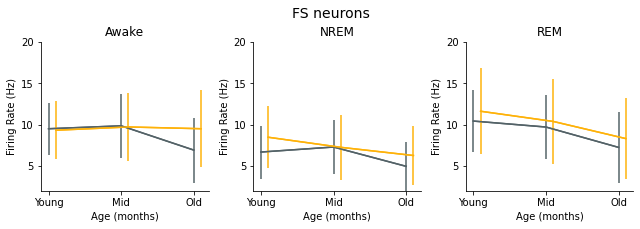

In [88]:
genotypes = ['WT', 'TE4']
variables = ['Awake', 'NREM', 'REM']
age_bins = FS_df.Age_bins.unique()

means = {genotype: {variable: [] for variable in variables} for genotype in genotypes}
sems = {genotype: {variable: [] for variable in variables} for genotype in genotypes}

for genotype in genotypes:
    for z in age_bins:
        for variable in variables:
            data = FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == genotype)][variable]
            genotype_means = np.mean(data)
            genotype_sems = np.nanstd(data) / (len(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == genotype)].AnimalName.unique()) ** 0.5)
            means[genotype][variable].append(genotype_means)
            sems[genotype][variable].append(genotype_sems)

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
fig.suptitle('FS neurons', fontsize=14)

plt.tight_layout()

colors = {'WT': sns.xkcd_rgb['gunmetal'],'TE4': sns.xkcd_rgb['saffron']}

labels = age_bins

for i, variable in enumerate(variables):
    for genotype in genotypes:
        x = np.arange(len(age_bins)) + (genotypes.index(genotype) * 0.1)
        y = means[genotype][variable]
        sem = sems[genotype][variable]
        ax[i].plot(x, y, color=colors[genotype])
        ax[i].errorbar(x, y, sem, color=colors[genotype])

    ax[i].set_xticks(range(len(age_bins)))
    ax[i].set_xticklabels(labels)
    ax[i].set_xlabel('Age (months)')
    ax[i].set_ylabel('Firing Rate (Hz)')
    ax[i].set_ylim([2, 20])
    ax[i].set_title(variable)

sns.despine()
plt.show()

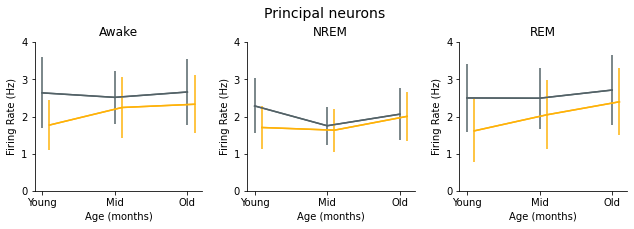

In [89]:
genotypes = ['WT', 'TE4']
variables = ['Awake', 'NREM', 'REM']
age_bins = Principal_df.Age_bins.unique()

means = {genotype: {variable: [] for variable in variables} for genotype in genotypes}
sems = {genotype: {variable: [] for variable in variables} for genotype in genotypes}

for genotype in genotypes:
    for z in age_bins:
        for variable in variables:
            data = Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == genotype)][variable]
            genotype_means = np.mean(data)
            genotype_sems = np.nanstd(data) / (len(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == genotype)].AnimalName.unique()) ** 0.5)
            means[genotype][variable].append(genotype_means)
            sems[genotype][variable].append(genotype_sems)

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
fig.suptitle('Principal neurons', fontsize=14)

plt.tight_layout()

colors = {'WT': sns.xkcd_rgb['gunmetal'],'TE4': sns.xkcd_rgb['saffron']}

labels = age_bins

for i, variable in enumerate(variables):
    for genotype in genotypes:
        x = np.arange(len(age_bins)) + (genotypes.index(genotype) * 0.1)
        y = means[genotype][variable]
        sem = sems[genotype][variable]
        ax[i].plot(x, y, color=colors[genotype])
        ax[i].errorbar(x, y, sem, color=colors[genotype])

    ax[i].set_xticks(range(len(age_bins)))
    ax[i].set_xticklabels(labels)
    ax[i].set_xlabel('Age (months)')
    ax[i].set_ylabel('Firing Rate (Hz)')
    ax[i].set_ylim([0, 4])
    ax[i].set_title(variable)

sns.despine()
plt.show()

/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


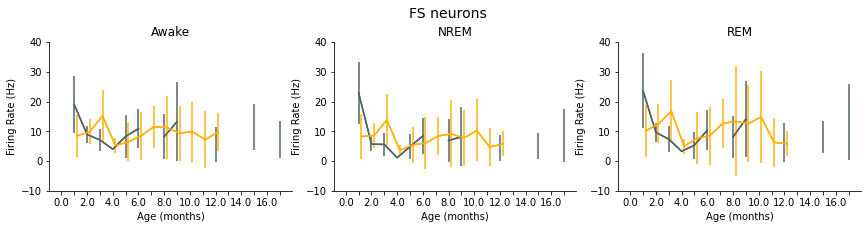

In [133]:
genotypes = ['WT', 'TE4']
variables = ['Awake', 'NREM', 'REM']
age_bins = np.arange(0, 550, 30)[:-1]

means = {genotype: {variable: [] for variable in variables} for genotype in genotypes}
sems = {genotype: {variable: [] for variable in variables} for genotype in genotypes}

for genotype in genotypes:
    for z in age_bins:
        for variable in variables:
            data = FS_df[(FS_df.Age_bins_month == z) & (FS_df.Geno == genotype)][variable]
            genotype_means = np.mean(data)
            genotype_sems = np.nanstd(data) / (len(FS_df[(FS_df.Age_bins_month == z) & (FS_df.Geno == genotype)].AnimalName.unique()) ** 0.5)
            means[genotype][variable].append(genotype_means)
            sems[genotype][variable].append(genotype_sems)

fig, ax = plt.subplots(1, 3, figsize=[12, 3])
fig.suptitle('FS neurons', fontsize=14)
plt.tight_layout()

colors = {'WT': sns.xkcd_rgb['gunmetal'],'TE4': sns.xkcd_rgb['saffron']}

labels = age_bins.astype(int)/30

for i, variable in enumerate(variables):
    for genotype in genotypes:
        x = np.arange(len(age_bins)) + (genotypes.index(genotype) * 0.2)
        y = means[genotype][variable]
        sem = sems[genotype][variable]
        ax[i].plot(x, y, color=colors[genotype])
        ax[i].errorbar(x, y, sem, color=colors[genotype])

    ax[i].set_xticks(range(len(age_bins)))
    ax[i].set_xticklabels(labels)
    
    # Show only every other x tick label
    for j, tick in enumerate(ax[i].get_xticklabels()):
        if j % 2 != 0:
            tick.set_visible(False)
            
    # Extend x-axis limits to show the gap
    ax[i].set_xlim(ax[i].get_xlim()[0] - 0.1, ax[i].get_xlim()[1] + 0.1)

    ax[i].set_xlabel('Age (months)')
    ax[i].set_ylabel('Firing Rate (Hz)')
    ax[i].set_ylim([-10, 40])
    ax[i].set_title(variable)

sns.despine()
plt.show()

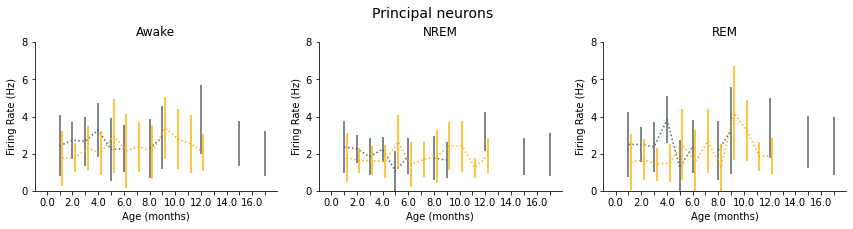

In [130]:
genotypes = ['WT', 'TE4']
variables = ['Awake', 'NREM', 'REM']
age_bins = np.arange(0, 550, 30)[:-1]

means = {genotype: {variable: [] for variable in variables} for genotype in genotypes}
sems = {genotype: {variable: [] for variable in variables} for genotype in genotypes}

for genotype in genotypes:
    for z in age_bins:
        for variable in variables:
            data = Principal_df[(Principal_df.Age_bins_month == z) & (Principal_df.Geno == genotype)][variable]
            genotype_means = np.mean(data)
            genotype_sems = np.nanstd(data) / (len(Principal_df[(Principal_df.Age_bins_month == z) & (Principal_df.Geno == genotype)].AnimalName.unique()) ** 0.5)
            means[genotype][variable].append(genotype_means)
            sems[genotype][variable].append(genotype_sems)

fig, ax = plt.subplots(1, 3, figsize=[12, 3])
fig.suptitle('Principal neurons', fontsize=14)
plt.tight_layout()

colors = {'WT': sns.xkcd_rgb['gunmetal'],'TE4': sns.xkcd_rgb['saffron']}

labels = age_bins.astype(int)/30

for i, variable in enumerate(variables):
    for genotype in genotypes:
        x = np.arange(len(age_bins)) + (genotypes.index(genotype) * 0.2)
        y = means[genotype][variable]
        sem = sems[genotype][variable]
        ax[i].plot(x, y, color=colors[genotype], ls = 'dotted')
        ax[i].errorbar(x, y, sem, color=colors[genotype], ls = '')

    ax[i].set_xticks(range(len(age_bins)))
    ax[i].set_xticklabels(labels)
    
    # Show only every other x tick label
    for j, tick in enumerate(ax[i].get_xticklabels()):
        if j % 2 != 0:
            tick.set_visible(False)
            
    # Extend x-axis limits to show the gap
    ax[i].set_xlim(ax[i].get_xlim()[0] - 0.1, ax[i].get_xlim()[1] + 0.1)

    ax[i].set_xlabel('Age (months)')
    ax[i].set_ylabel('Firing Rate (Hz)')
    ax[i].set_ylim([0, 8])
    ax[i].set_title(variable)

sns.despine()
plt.show()

In [132]:
variable

'REM'

In [100]:
genotypes = ['WT', 'TE4']
variables = ['Awake', 'NREM', 'REM']
age_bins = np.arange(0, 550, 30)[:-1]

means = {genotype: {variable: [] for variable in variables} for genotype in genotypes}
sems = {genotype: {variable: [] for variable in variables} for genotype in genotypes}

for genotype in genotypes:
    for z in age_bins:
        for variable in variables:
            data = Principal_df[(Principal_df.Age_bins_month == z) & (Principal_df.Geno == genotype)][variable]
            genotype_means = np.mean(data)
            genotype_sems = np.nanstd(data) / (len(Principal_df[(Principal_df.Age_bins_month == z) & (Principal_df.Geno == genotype)].AnimalName.unique()) ** 0.5)
            means[genotype][variable].append(genotype_means)
            sems[genotype][variable].append(genotype_sems)

fig, ax = plt.subplots(1, 3, figsize=[12, 3])
fig.suptitle('Principal neurons', fontsize=14)
plt.tight_layout()

colors = {'WT': sns.xkcd_rgb['gunmetal'],'TE4': sns.xkcd_rgb['saffron']}

labels = age_bins.astype(int)/30

for i, variable in enumerate(variables):
    
    sns.violinplot(data = Principal_df[Principal_df.Age_bins_month == z], x = 'Age-')
    
    for genotype in genotypes:
        x = np.arange(len(age_bins)) + (genotypes.index(genotype) * 0.2)
        y = means[genotype][variable]
        sem = sems[genotype][variable]
        ax[i].plot(x, y, color=colors[genotype], ls = 'dotted')

    ax[i].set_xticks(range(len(age_bins)))
    ax[i].set_xticklabels(labels)
    
    # Show only every other x tick label
    for j, tick in enumerate(ax[i].get_xticklabels()):
        if j % 2 != 0:
            tick.set_visible(False)
            
    # Extend x-axis limits to show the gap
    ax[i].set_xlim(ax[i].get_xlim()[0] - 0.1, ax[i].get_xlim()[1] + 0.1)

    ax[i].set_xlabel('Age (months)')
    ax[i].set_ylabel('Firing Rate (Hz)')
    ax[i].set_ylim([0, 8])
    ax[i].set_title(variable)

sns.despine()
plt.show()

,Awake,Qwake,NREM,REM,PeakLatency,OverallFR,CellQuality,CellType,AnimalName,Age,Geno,Age_bins,Age_bins_month
2,2.951504,2.143434,2.991890,5.950000,0.60,2.999236,2,RSU,kdr27,56.120081,WT,Young,30
5,2.605779,3.302525,4.828369,2.908571,0.76,3.477778,2,RSU,kdr27,56.120081,WT,Young,30
7,0.239699,0.689394,1.171504,0.894661,1.00,0.648542,1,RSU,kdr27,56.120081,WT,Young,30
9,3.402182,2.226768,3.231611,4.135714,0.76,3.218264,2,RSU,kdr27,56.120081,WT,Young,30
10,2.450177,2.069697,1.925025,1.598571,0.60,2.176736,1,RSU,kdr27,56.120081,WT,Young,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.457264,1.091544,0.296158,0.745455,0.88,0.757175,1,RSU,caf88,532.382535,WT,Old,510
69,2.195908,2.474803,3.649532,3.472028,0.68,3.070460,2,RSU,caf88,532.382535,WT,Old,510
70,0.386616,0.461900,0.657633,0.641958,0.72,0.554351,1,RSU,caf88,532.382535,WT,Old,510
71,0.257282,0.306618,0.461549,0.428322,1.00,0.381157,1,RSU,caf88,532.382535,WT,Old,510


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encou

KeyboardInterrupt: 

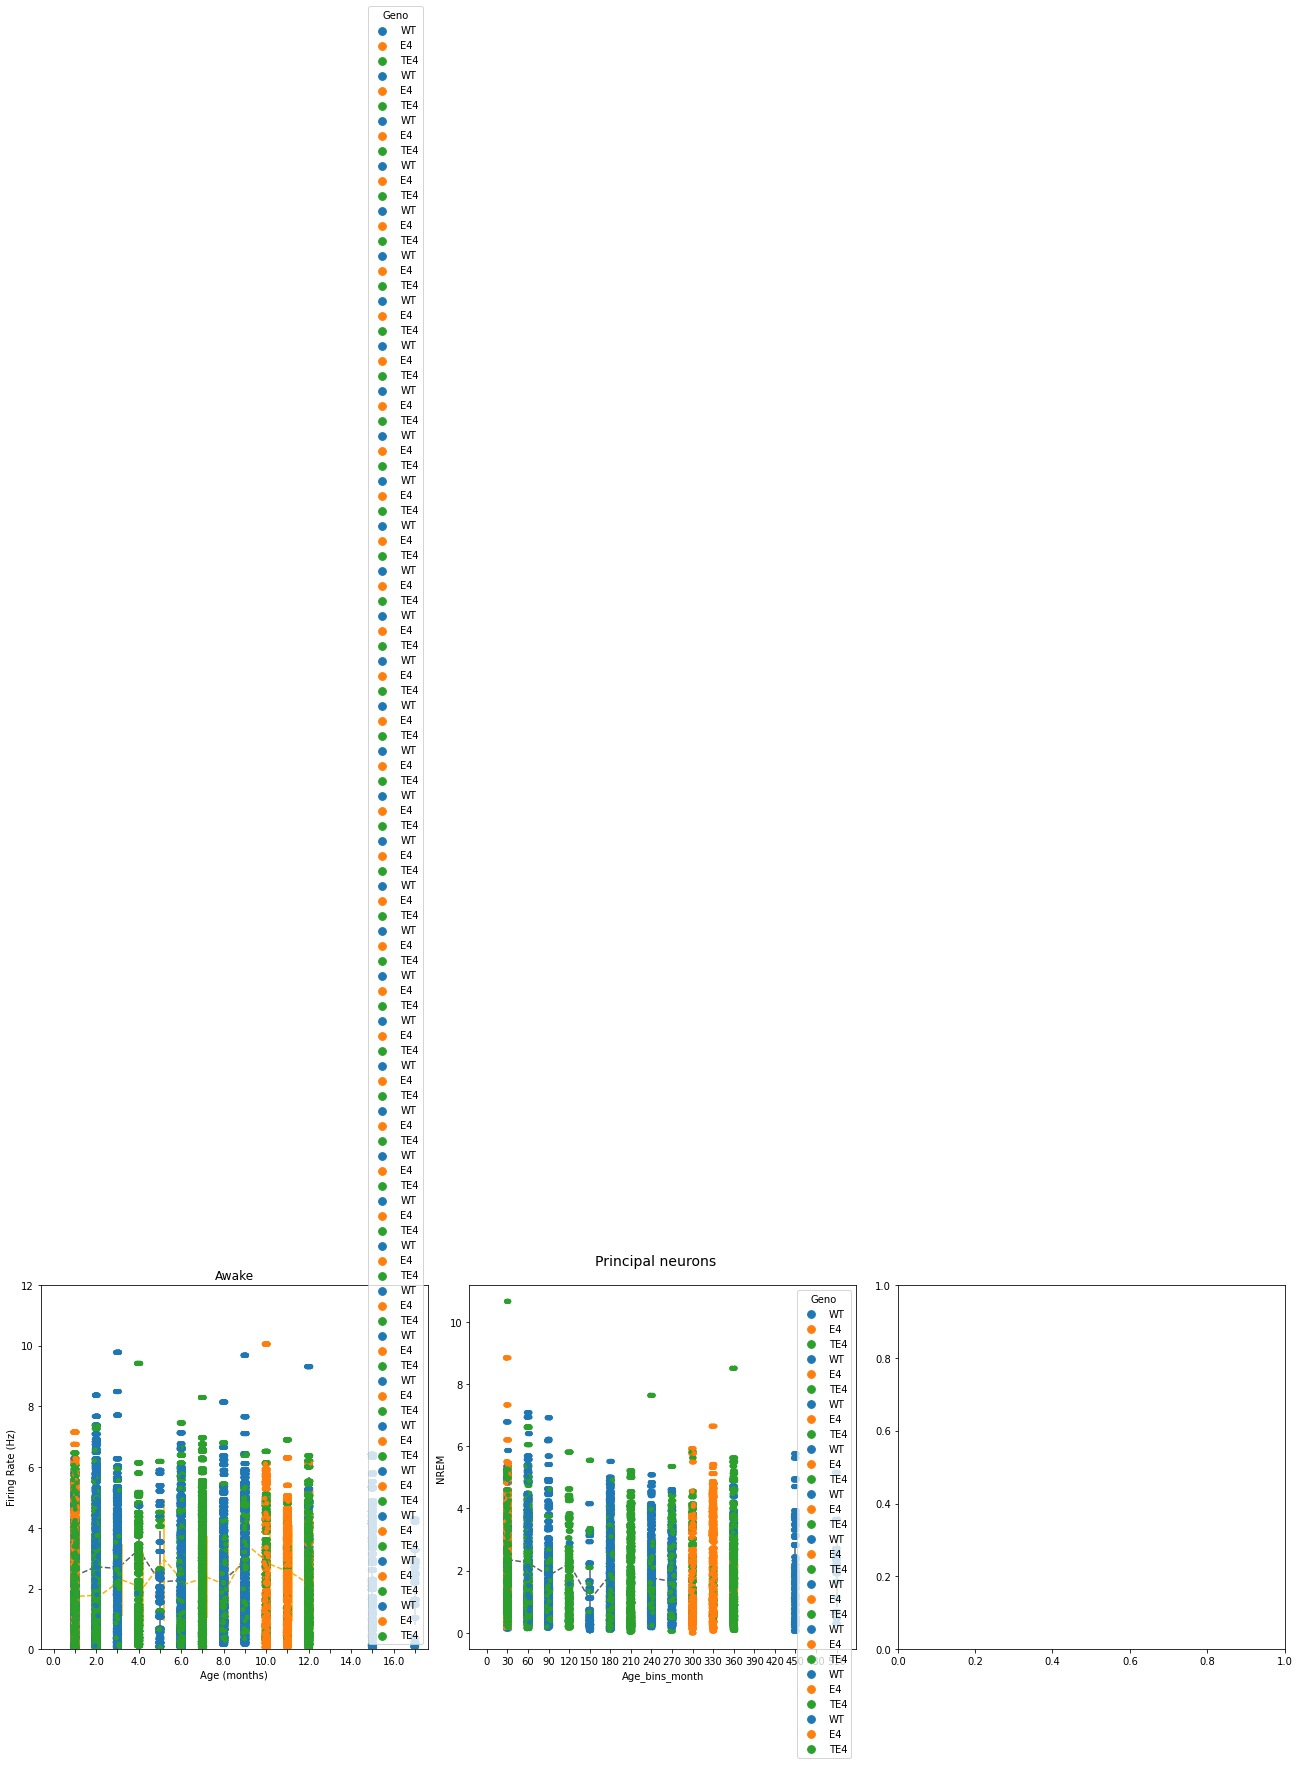

In [115]:
genotypes = ['WT', 'TE4']
variables = ['Awake', 'NREM', 'REM']
age_bins = np.arange(0, 550, 30)[:-1]

means = {genotype: {variable: [] for variable in variables} for genotype in genotypes}
sems = {genotype: {variable: [] for variable in variables} for genotype in genotypes}

# Collect means and standard errors
for genotype in genotypes:
    for z in age_bins:
        for variable in variables:
            data = Principal_df[(Principal_df.Age_bins_month == z) & (Principal_df.Geno == genotype)][variable]
            genotype_means = np.mean(data)
            genotype_sems = np.nanstd(data) / (len(Principal_df[(Principal_df.Age_bins_month == z) & (Principal_df.Geno == genotype)].AnimalName.unique()) ** 0.5)
            means[genotype][variable].append(genotype_means)
            sems[genotype][variable].append(genotype_sems)

# Create figure and axes
fig, ax = plt.subplots(1, 3, figsize=[18, 6])
fig.suptitle('Principal neurons', fontsize=14)
plt.tight_layout()

colors = {'WT': sns.xkcd_rgb['gunmetal'], 'TE4': sns.xkcd_rgb['saffron']}
labels = age_bins.astype(int) / 30

# Plot means with error bars and swarm plots
for i, variable in enumerate(variables):
    for genotype in genotypes:
        x = np.arange(len(age_bins)) + (genotypes.index(genotype) * 0.2)
        y = means[genotype][variable]
        sem = sems[genotype][variable]
        ax[i].plot(x, y, color=colors[genotype], ls = '--')
        ax[i].errorbar(x, y, sem, color=colors[genotype], linestyle = '')
#         sns.boxplot(data = Principal_df, x = 'Age_bins_month', y = variable, ax = ax[i], hue = 'Geno' )

        # Create swarm plot for each age bin
        for j, z in enumerate(age_bins):
            tempdf = Principal_df[Principal_df.Age_bins_month == z]
            swarm_data = Principal_df[(Principal_df.Age_bins_month == z) & (Principal_df.Geno == genotype)][variable]
#             swarm_x = np.full_like(swarm_data, x[j])
#             ax[i].scatter(swarm_x, swarm_data, color=colors[genotype], s= 1, alpha=0.2)
            sns.stripplot(data = Principal_df, x = 'Age_bins_month', y = variable, ax = ax[i], hue = 'Geno')

    ax[i].set_xticks(range(len(age_bins)))
    ax[i].set_xticklabels(labels)

    # Show only every other x tick label
    for j, tick in enumerate(ax[i].get_xticklabels()):
        if j % 2 != 0:
            tick.set_visible(False)

    # Extend x-axis limits to show the gap
    ax[i].set_xlim(ax[i].get_xlim()[0] - 0.1, ax[i].get_xlim()[1] + 0.1)

    ax[i].set_xlabel('Age (months)')
    ax[i].set_ylabel('Firing Rate (Hz)')
    ax[i].set_ylim([0, 12])
    ax[i].set_title(variable)

sns.despine()
plt.show()

In [126]:
tempdf = Principal_df[Principal_df.Age_bins_month == 150]
tempdf

,Awake,Qwake,NREM,REM,PeakLatency,OverallFR,CellQuality,CellType,AnimalName,Age,Geno,Age_bins,Age_bins_month
1,4.856013,5.447158,1.111869,1.724662,0.68,3.846145,2,RSU,caf34,156.421007,WT,Mid,150
2,1.873418,2.138988,0.372500,0.518581,0.52,1.468472,2,RSU,caf34,156.421007,WT,Mid,150
5,2.609395,2.989787,0.416415,1.042230,0.36,2.026146,2,FS,caf34,156.421007,WT,Mid,150
6,2.071978,1.541741,1.350597,1.305743,0.76,1.823507,1,RSU,caf34,156.421007,WT,Mid,150
8,0.099077,0.088810,0.130840,0.163851,0.96,0.107986,2,RSU,caf34,156.421007,WT,Mid,150
9,5.891805,3.575044,3.126655,5.130068,0.72,4.962708,1,RSU,caf34,156.421007,WT,Mid,150
10,0.555640,0.277531,0.186614,0.331081,1.28,0.431458,1,RSU,caf34,156.421007,WT,Mid,150
16,2.012127,0.832547,0.389366,0.379428,0.64,1.380382,2,RSU,caf34,156.421007,WT,Mid,150
17,3.222902,1.570755,0.428162,0.569095,0.48,2.148715,2,RSU,caf34,156.421007,WT,Mid,150
20,1.135789,0.757075,0.727736,0.634196,0.32,0.971007,2,FS,caf34,156.421007,WT,Mid,150


300

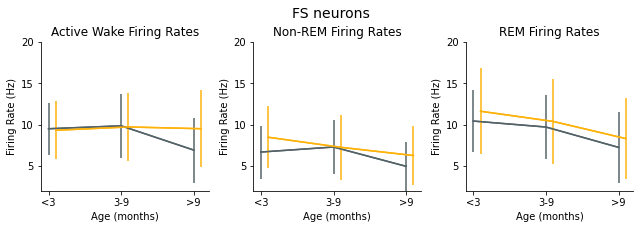

In [18]:
awake_means_WT = []
nrem_means_WT = []
rem_means_WT = []
for z in FS_df.Age_bins.unique():
    awake_means_WT.append(np.mean(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].Awake))
    nrem_means_WT.append(np.mean(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].NREM))
    rem_means_WT.append(np.mean(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].REM))
    
awake_means_TE4 = []
nrem_means_TE4 = []
rem_means_TE4 = []
for z in FS_df.Age_bins.unique():
    awake_means_TE4.append(np.mean(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].Awake))
    nrem_means_TE4.append(np.mean(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].NREM))
    rem_means_TE4.append(np.mean(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].REM))

awake_sems_WT = []
nrem_sems_WT = []
rem_sems_WT = []
for z in FS_df.Age_bins.unique():
    awake_sems_WT.append(np.nanstd(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].Awake)/
                      (len(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].AnimalName.unique())**0.5))
    nrem_sems_WT.append(np.nanstd(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].NREM)/
                      (len(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].AnimalName.unique())**0.5))
    rem_sems_WT.append(np.nanstd(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].REM)/
                      (len(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'WT')].AnimalName.unique())**0.5))
    
awake_sems_TE4 = []
nrem_sems_TE4 = []
rem_sems_TE4 = []
for z in FS_df.Age_bins.unique():
    awake_sems_TE4.append(np.nanstd(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].Awake)/
                      (len(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].AnimalName.unique())**0.5))
    nrem_sems_TE4.append(np.nanstd(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].NREM)/
                      (len(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].AnimalName.unique())**0.5))
    rem_sems_TE4.append(np.nanstd(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].REM)/
                      (len(FS_df[(FS_df.Age_bins == z) & (FS_df.Geno == 'TE4')].AnimalName.unique())**0.5))
    
    
fig, ax = plt.subplots(1,3,figsize=[9,3])
fig.suptitle('FS neurons', fontsize=14)

plt.tight_layout()

ax[0].plot([0,1,2], awake_means_WT, color=sns.xkcd_rgb['gunmetal'])
ax[0].errorbar([0,1,2], awake_means_WT, awake_sems_WT, color=sns.xkcd_rgb['gunmetal'])
ax[0].plot([0.1,1.1,2.1], awake_means_TE4, color=sns.xkcd_rgb['saffron'])
ax[0].errorbar([0.1,1.1,2.1], awake_means_TE4, awake_sems_TE4, color=sns.xkcd_rgb['saffron'])

ax[1].plot([0,1,2], nrem_means_WT, color=sns.xkcd_rgb['gunmetal'])
ax[1].errorbar([0,1,2], nrem_means_WT, nrem_sems_WT, color=sns.xkcd_rgb['gunmetal'])
ax[1].plot([0.1,1.1,2.1], nrem_means_TE4, color=sns.xkcd_rgb['saffron'])
ax[1].errorbar([0.1,1.1,2.1], nrem_means_TE4, nrem_sems_TE4, color=sns.xkcd_rgb['saffron'])

ax[2].plot([0,1,2], rem_means_WT, color=sns.xkcd_rgb['gunmetal'])
ax[2].errorbar([0,1,2], rem_means_WT, rem_sems_WT, color=sns.xkcd_rgb['gunmetal'])
ax[2].plot([0.1,1.1,2.1], rem_means_TE4, color=sns.xkcd_rgb['saffron'])
ax[2].errorbar([0.1,1.1,2.1], rem_means_TE4, rem_sems_TE4, color=sns.xkcd_rgb['saffron'])

for z in np.arange(0,3):
    ax[z].set_xticks([0,1,2],['<3','3-9','>9'])
    ax[z].set_xlabel('Age (months)')
    ax[z].set_ylabel('Firing Rate (Hz)')
    
    ax[z].set_ylim([2,20])
    
ax[0].set_title('Active Wake Firing Rates')
ax[1].set_title('Non-REM Firing Rates')
ax[2].set_title('REM Firing Rates')

sns.despine()



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


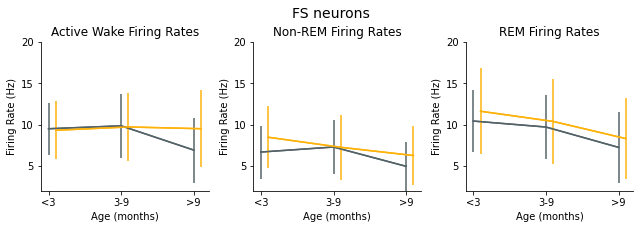

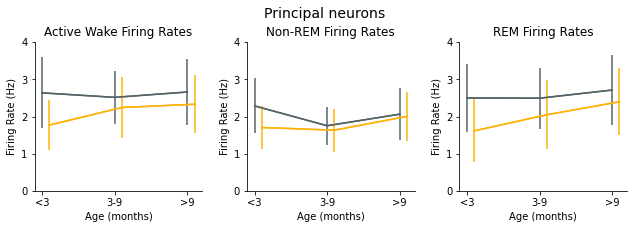

In [17]:
awake_means_WT = []
nrem_means_WT = []
rem_means_WT = []
for z in Principal_df.Age_bins.unique():
    awake_means_WT.append(np.mean(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].Awake))
    nrem_means_WT.append(np.mean(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].NREM))
    rem_means_WT.append(np.mean(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].REM))
    
awake_means_TE4 = []
nrem_means_TE4 = []
rem_means_TE4 = []
for z in Principal_df.Age_bins.unique():
    awake_means_TE4.append(np.mean(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].Awake))
    nrem_means_TE4.append(np.mean(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].NREM))
    rem_means_TE4.append(np.mean(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].REM))

awake_sems_WT = []
nrem_sems_WT = []
rem_sems_WT = []
for z in Principal_df.Age_bins.unique():
    awake_sems_WT.append(np.nanstd(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].Awake)/
                      (len(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].AnimalName.unique())**0.5))
    nrem_sems_WT.append(np.nanstd(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].NREM)/
                      (len(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].AnimalName.unique())**0.5))
    rem_sems_WT.append(np.nanstd(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].REM)/
                      (len(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'WT')].AnimalName.unique())**0.5))
    
awake_sems_TE4 = []
nrem_sems_TE4 = []
rem_sems_TE4 = []
for z in Principal_df.Age_bins.unique():
    awake_sems_TE4.append(np.nanstd(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].Awake)/
                      (len(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].AnimalName.unique())**0.5))
    nrem_sems_TE4.append(np.nanstd(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].NREM)/
                      (len(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].AnimalName.unique())**0.5))
    rem_sems_TE4.append(np.nanstd(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].REM)/
                      (len(Principal_df[(Principal_df.Age_bins == z) & (Principal_df.Geno == 'TE4')].AnimalName.unique())**0.5))
    
    
fig, ax = plt.subplots(1,3,figsize=[9,3])
fig.suptitle('Principal neurons', fontsize=14)

plt.tight_layout()

ax[0].plot([0,1,2], awake_means_WT, color=sns.xkcd_rgb['gunmetal'])
ax[0].errorbar([0,1,2], awake_means_WT, awake_sems_WT, color=sns.xkcd_rgb['gunmetal'])
ax[0].plot([0.1,1.1,2.1], awake_means_TE4, color=sns.xkcd_rgb['saffron'])
ax[0].errorbar([0.1,1.1,2.1], awake_means_TE4, awake_sems_TE4, color=sns.xkcd_rgb['saffron'])

ax[1].plot([0,1,2], nrem_means_WT, color=sns.xkcd_rgb['gunmetal'])
ax[1].errorbar([0,1,2], nrem_means_WT, nrem_sems_WT, color=sns.xkcd_rgb['gunmetal'])
ax[1].plot([0.1,1.1,2.1], nrem_means_TE4, color=sns.xkcd_rgb['saffron'])
ax[1].errorbar([0.1,1.1,2.1], nrem_means_TE4, nrem_sems_TE4, color=sns.xkcd_rgb['saffron'])

ax[2].plot([0,1,2], rem_means_WT, color=sns.xkcd_rgb['gunmetal'])
ax[2].errorbar([0,1,2], rem_means_WT, rem_sems_WT, color=sns.xkcd_rgb['gunmetal'])
ax[2].plot([0.1,1.1,2.1], rem_means_TE4, color=sns.xkcd_rgb['saffron'])
ax[2].errorbar([0.1,1.1,2.1], rem_means_TE4, rem_sems_TE4, color=sns.xkcd_rgb['saffron'])

for z in np.arange(0,3):
    ax[z].set_xticks([0,1,2],['<3','3-9','>9'])
    ax[z].set_xlabel('Age (months)')
    ax[z].set_ylabel('Firing Rate (Hz)')
    
    ax[z].set_ylim([0,4])
    
ax[0].set_title('Active Wake Firing Rates')
ax[1].set_title('Non-REM Firing Rates')
ax[2].set_title('REM Firing Rates')

sns.despine()

# Now for supplemental figures and stats plots:

# Starting with boxen plots:

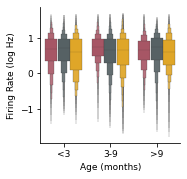

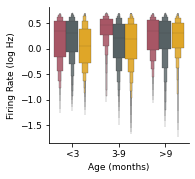

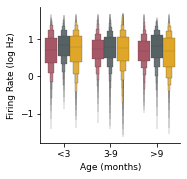

In [28]:
def plotboxen(df_, today, basedir, celltypestring, SAVEFIGS):
    
    plt.figure(figsize=[2.5,2.5])
    col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

    ax = sns.boxenplot(x = 'bins', y = 'logfr', hue = 'geno', showfliers=False, palette = col_palette, data=df_, linewidth = 0.25)

    plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
    plt.xlabel('Age (months)', fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel('Firing Rate (log Hz)', fontsize=9)
    ax.get_legend().remove()

    sns.despine()

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_boxen_FRs_{celltypestring}.pdf')
        
df_ = dfall_FR
celltypestring = 'ensemble'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.celltype == 'RSU') & (dfall_FR.fr <5)]
celltypestring = 'just_RSU'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.celltype == 'FS')]
celltypestring = 'just_FS'
plotboxen(df_, today, basedir, celltypestring, SAVEFIGS)

# Now LME p-value scatters:

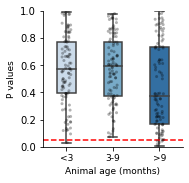

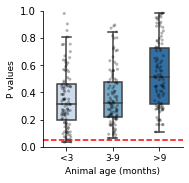

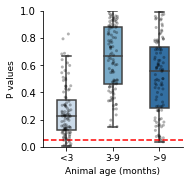

In [41]:
fig, ax = plt.subplots(figsize=[2.5, 2.5])

celltypestring = 'ensemble'
#Previous run of LME:
#fr_young = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/fr_young.csv')
#fr_mid = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/fr_mid.csv')
#fr_old = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/fr_old.csv')

#Newest:
fr_young = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_young_ensemble.csv')
fr_mid = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_mid_ensemble.csv')
fr_old = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_old_ensemble.csv')

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(fr_young.x), np.array(fr_mid.x), np.array(fr_old.x)])
xs = np.concatenate([np.ones(len(fr_young.x))*0, np.ones(len(fr_mid.x))*.5, np.ones(len(fr_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 

sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.4, palette = 'Blues', showfliers=False)
plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')

plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

#plt.gcf().subplots_adjust(left=0.2)

sns.despine(ax=ax)

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_LME_FRs_pvals_{celltypestring}.pdf')

# --------------------------------------------------------------------------------------------------------    
fig, ax = plt.subplots(figsize=[2.5, 2.5])
celltypestring = 'just_RSU'

fr_young = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_young_justRSU.csv')
fr_mid = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_mid_justRSU.csv')
fr_old = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_old_justRSU.csv')

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(fr_young.x), np.array(fr_mid.x), np.array(fr_old.x)])
xs = np.concatenate([np.ones(len(fr_young.x))*0, np.ones(len(fr_mid.x))*.5, np.ones(len(fr_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 

sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.4, palette = 'Blues', showfliers=False)
plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')

plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

#plt.gcf().subplots_adjust(left=0.2)

sns.despine(ax=ax)

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_LME_FRs_pvals_{celltypestring}.pdf')

# --------------------------------------------------------------------------------------------------------    
fig, ax = plt.subplots(figsize=[2.5, 2.5])
celltypestring = 'just_FS'

fr_young = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_young_justFS.csv')
fr_mid = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_mid_justFS.csv')
fr_old = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/FINAL_fr_old_justFS.csv')

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(fr_young.x), np.array(fr_mid.x), np.array(fr_old.x)])
xs = np.concatenate([np.ones(len(fr_young.x))*0, np.ones(len(fr_mid.x))*.5, np.ones(len(fr_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 

sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.4, palette = 'Blues', showfliers=False)
plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')
plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

#plt.gcf().subplots_adjust(left=0.2)

sns.despine(ax=ax)

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_LME_FRs_pvals_{celltypestring}.pdf')

# --------------------------------------------------------------------------------------------------------    

    

# Now hierarchical bootstrap:

0.6120666666666671
0.5590111111111112
0.4580666666666671
0.19628888888888893
0.3126222222222222
0.4086666666666671
0.8821111111111113
0.6881777777777781
0.5366000000000003


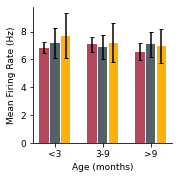

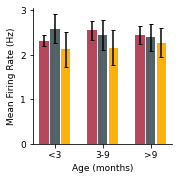

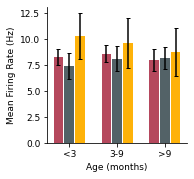

In [29]:
def plothierbootstrap(df_, today, basedir, celltypestring, SAVEFIGS):

    bins = [0, 91, 274, 700]

    wt_mean = []
    wt_sem = []
    te4_mean = []
    te4_sem = []
    e4_mean = []
    e4_sem = []
    num_wts = []
    num_te4s = []
    num_e4s = []

    for h in np.arange(0,len(bins)-1):

        try:

            thisdf = []
            thisdf = df_[df_.age_days > bins[h]]
            thisdf = df_[df_.age_days < bins[h+1]]

            animal_array_temp = thisdf.animal.unique()

            wt_temp = []
            te4_temp = []
            e4_temp = []

            for a in animal_array_temp:
                temparray = []
                temparray = thisdf[thisdf.animal == a]

                if temparray.geno.unique()[0] == 'wt':
                    wt_temp.append(np.asarray(temparray.fr))
                elif temparray.geno.unique()[0] == 'te4':
                    te4_temp.append(np.asarray(temparray.fr))
                elif temparray.geno.unique()[0] == 'e4':
                    e4_temp.append(np.asarray(temparray.fr))


            num_wts.append(len(wt_temp))
            num_te4s.append(len(te4_temp))
            num_e4s.append(len(e4_temp))

            nboot = 10000 

            bootstrapping_matrix1 = np.zeros([nboot,1,len(wt_temp)])
            for a in np.arange(0,len(wt_temp)): #loop thru number of te4 animals
                temp = []
                temp = wt_temp[a]
                for n in np.arange(0,nboot):
                    bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0]

            bootstrapping_matrix2 = np.zeros([nboot,1,len(te4_temp)])
            for a in np.arange(0,len(te4_temp)): #loop thru number of te4 animals
                temp = []
                temp = te4_temp[a]
                for n in np.arange(0,nboot):
                    bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]


            bootstrapping_matrix3 = np.zeros([nboot,1,len(e4_temp)])
            for a in np.arange(0,len(e4_temp)): #loop thru number of e4 animals
                temp = []
                temp = e4_temp[a]
                for n in np.arange(0,nboot):
                    bootstrapping_matrix3[n,0,a] = choices(temp, k=1)[0]


            nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
            bootstats1 = np.zeros([nboot2,1])
            bootstats2 = np.zeros([nboot2,1])
            bootstats3 = np.zeros([nboot2,1])

            for n in np.arange(0,nboot2):
                temp_animals = []
                temp_animals = choices(np.arange(0,len(wt_temp)), k=3)

                tempdata = []
                for t in np.arange(0,len(temp_animals)):

                    temp_pulls = choices(np.arange(0,nboot), k=nboot)
                    tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_animals[t]])
                    #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                    #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

                #wt_boot_means.append(np.nanmean(tempdata))
                bootstats1[n] = np.nanmean(tempdata)


            for n in np.arange(0,nboot2):
                temp_animals =[]
                temp_animals = choices(np.arange(0,len(te4_temp)), k=3)

                tempdata = []
                for t in np.arange(0,len(temp_animals)):

                    temp_pulls = choices(np.arange(0,nboot), k=nboot)
                    tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_animals[t]])
                    #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                    #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

                #wt_boot_means.append(np.nanmean(tempdata))
                bootstats2[n] = np.nanmean(tempdata)

            for n in np.arange(0,nboot2):
                temp_animals = []
                temp_animals = choices(np.arange(0,len(e4_temp)), k=3)

                tempdata = []
                for t in np.arange(0,len(temp_animals)):

                    temp_pulls = choices(np.arange(0,nboot), k=nboot)
                    tempdata.append(bootstrapping_matrix3[temp_pulls,:,temp_animals[t]])
                    #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                    #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

                #wt_boot_means.append(np.nanmean(tempdata))
                bootstats3[n] = np.nanmean(tempdata)

            bootstats1 = bootstats1.flatten()
            bootstats2 = bootstats2.flatten()
            bootstats3 = bootstats3.flatten()

            wt_mean.append(np.nanmean(bootstats1))
            wt_sem.append(np.nanstd(bootstats1))
            te4_mean.append(np.nanmean(bootstats2))
            te4_sem.append(np.nanstd(bootstats2))
            e4_mean.append(np.nanmean(bootstats3))
            e4_sem.append(np.nanstd(bootstats3))

            sample1 = bootstats1
            sample2 = bootstats2

            joint_low_val = np.min([np.min(sample1), np.min(sample2)])
            joint_high_val = np.max([np.max(sample1), np.max(sample2)])

            p_joint_matrix = np.zeros([100,100])

            p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
            edge_shift = (p_axis[1] - p_axis[0])/2 
            p_axis_edges = p_axis - edge_shift
            p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

            def histc(X, bins):
                map_to_bins = np.digitize(X,bins)
                r = np.zeros(bins.shape)
                for i in map_to_bins:
                    r[i-1] += 1
                return [r, map_to_bins]

            p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
            p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


            for i in np.arange(0, np.shape(p_joint_matrix)[0]):
                for j in np.arange(0,np.shape(p_joint_matrix)[1]):
                    p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

            #p_joint_matrix
            p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
            p_test = sum(sum(np.triu(p_joint_matrix)));

            print(p_test)

        except:

            print(f'issue with loop number {a}')


    fig, ax = plt.subplots(1,figsize = (2.5,2.5))

    color_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'],sns.xkcd_rgb['saffron']]

    ax.bar([0,.9,1.8], [e4_mean[0], wt_mean[0], te4_mean[0]], yerr=[e4_sem[0], wt_sem[0], te4_sem[0]], 
           align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

    ax.bar([4,4.9,5.8], [e4_mean[1], wt_mean[1], te4_mean[1]], yerr=[e4_sem[1], wt_sem[1], te4_sem[1]], 
           align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

    ax.bar([8,8.9,9.8], [e4_mean[2], wt_mean[2], te4_mean[2]], yerr=[e4_sem[2], wt_sem[2], te4_sem[2]], 
           align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

    ax.set_ylabel('Mean Firing Rate (Hz)', fontsize = 9)
    plt.yticks(fontsize = 9)
    ax.set_xticks([.9,4.9,8.9],['<3','3-9','>9'], fontsize = 9)
    ax.set_xlabel('Age (months)', fontsize = 9)

    sns.despine()

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_hierarchbootstrap_FRs_{celltypestring}.pdf')
    
df_ = dfall_FR
celltypestring = 'ensemble'
plothierbootstrap(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.celltype == 'RSU') & (dfall_FR.fr <5)]
celltypestring = 'just_RSU'
plothierbootstrap(df_, today, basedir, celltypestring, SAVEFIGS)

df_ = dfall_FR[(dfall_FR.cellqual <3) & (dfall_FR.celltype == 'FS')]
celltypestring = 'just_FS'
plothierbootstrap(df_, today, basedir, celltypestring, SAVEFIGS)



# Calculate the number of FS and RSUs between genos over time:

Ttest_indResult(statistic=-1.6838013914794097, pvalue=0.11803097746771676)
Ttest_indResult(statistic=-0.7118343378159984, pvalue=0.484400900637727)
Ttest_indResult(statistic=-1.7261723742646813, pvalue=0.11502269948575965)
Ttest_indResult(statistic=-1.20184023969073, pvalue=0.25260703509975546)
Ttest_indResult(statistic=-1.1926617020496075, pvalue=0.24630419822565797)
Ttest_indResult(statistic=-0.7782930929594283, pvalue=0.4544173501527514)
Ttest_indResult(statistic=-1.5153892792706183, pvalue=0.15556322585854482)
Ttest_indResult(statistic=-0.22827582415355593, pvalue=0.8216399552304607)
Ttest_indResult(statistic=-2.0340067060500044, pvalue=0.07246374180965857)


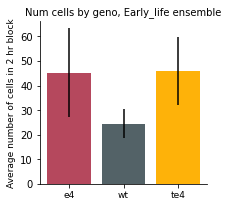

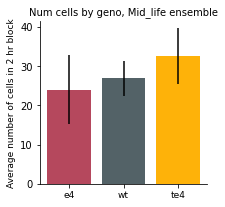

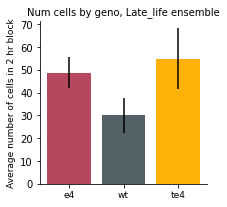

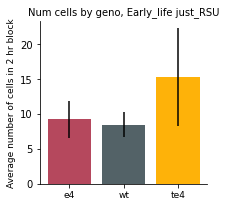

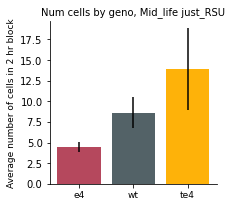

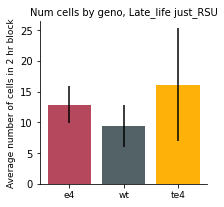

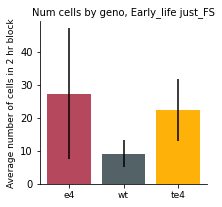

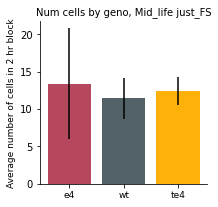

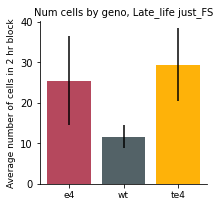

In [31]:
def plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS):
    
    tmpe4 = []
    tmpe4 = df_tmp[df_tmp.geno == 'e4']
    tmpwt = []
    tmpwt = df_tmp[df_tmp.geno == 'wt']
    tmpte4 = [] 
    tmpte4 = df_tmp[df_tmp.geno == 'te4']
    
    num_cells_per_e4 = []
    for a in tmpe4.animal.unique():
        tmpdf = []
        tmpdf = tmpe4[tmpe4.animal == a]
        num_cells_per_e4.append(len(tmpdf.fr)/len(tmpdf.time.unique()))
    num_cells_per_wt = []
    for a in tmpwt.animal.unique():
        tmpdf = []
        tmpdf = tmpwt[tmpwt.animal == a]
        num_cells_per_wt.append(len(tmpdf.fr)/len(tmpdf.time.unique()))
    num_cells_per_te4 = []
    for a in tmpte4.animal.unique():
        tmpdf = []
        tmpdf = tmpte4[tmpte4.animal == a]
        num_cells_per_te4.append(len(tmpdf.fr)/len(tmpdf.time.unique()))

    plt.figure(figsize=[3,3])
    plt.bar(0, np.mean(num_cells_per_e4), color=sns.xkcd_rgb['dark rose'])
    plt.errorbar(0, np.mean(num_cells_per_e4), scipy.stats.sem(num_cells_per_e4), color='black')
    plt.bar(1, np.mean(num_cells_per_wt), color=sns.xkcd_rgb['gunmetal'])
    plt.errorbar(1, np.mean(num_cells_per_wt), scipy.stats.sem(num_cells_per_wt), color='black')
    plt.bar(2, np.mean(num_cells_per_te4), color=sns.xkcd_rgb['saffron'])
    plt.errorbar(2, np.mean(num_cells_per_te4), scipy.stats.sem(num_cells_per_te4), color='black')
    plt.xticks([0,1,2],['e4','wt','te4'], fontsize=9)
    plt.ylabel('Average number of cells in 2 hr block', fontsize=9)
    plt.title(f'Num cells by geno, {age_bin} {celltypestring}', fontsize=10)
    sns.despine()
    print(scipy.stats.ttest_ind(num_cells_per_wt,num_cells_per_te4))

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_num_cells_by_geno_{celltypestring}_{age_bin}.pdf')
        
df_tmp = dfall_FR[dfall_FR.age_days < 91]
age_bin = 'Early_life'
celltypestring = 'ensemble'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)
df_tmp = dfall_FR[(dfall_FR.age_days > 91) & (dfall_FR.age_days < 274)]
age_bin = 'Mid_life'
celltypestring = 'ensemble'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)
df_tmp = dfall_FR[dfall_FR.age_days > 274]
age_bin = 'Late_life'
celltypestring = 'ensemble'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)


df_tmp = dfall_FR[(dfall_FR.age_days < 91) & (dfall_FR.cellqual <3) & (dfall_FR.celltype == 'RSU') & (dfall_FR.fr <5)]
age_bin = 'Early_life'
celltypestring = 'just_RSU'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)
df_tmp = dfall_FR[(dfall_FR.age_days > 91) & (dfall_FR.age_days < 274) & (dfall_FR.cellqual <3) & (dfall_FR.celltype == 'RSU') & (dfall_FR.fr <5)]
age_bin = 'Mid_life'
celltypestring = 'just_RSU'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)
df_tmp = dfall_FR[(dfall_FR.age_days > 274) & (dfall_FR.cellqual <3) & (dfall_FR.celltype == 'RSU') & (dfall_FR.fr <5)]
age_bin = 'Late_life'
celltypestring = 'just_RSU'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)

df_tmp = dfall_FR[(dfall_FR.age_days < 91) & (dfall_FR.cellqual <3) & (dfall_FR.celltype == 'FS')]
age_bin = 'Early_life'
celltypestring = 'just_FS'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)
df_tmp = dfall_FR[(dfall_FR.age_days > 91) & (dfall_FR.age_days < 274) & (dfall_FR.cellqual <3) & (dfall_FR.celltype == 'FS')]
age_bin = 'Mid_life'
celltypestring = 'just_FS'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)
df_tmp = dfall_FR[(dfall_FR.age_days > 274) & (dfall_FR.cellqual <3) & (dfall_FR.celltype == 'FS')]
age_bin = 'Late_life'
celltypestring = 'just_FS'
plotnumcells(df_tmp, age_bin, today, basedir, celltypestring, SAVEFIGS)



# Extra code:

In [ ]:
def make_fr_plots_wt(df_FR, today, basedir, celltypestring, SAVEFIGS):
    
    fig,ax = plt.subplots(figsize=[3,2])
    #df_FR = df_FR_young_wt
    start_age = np.min(df_FR_young_wt.age_days)
    age_days_bins = []
    age_days_bins = np.arange(start_age,start_age+14.1,1/6)
    df_FR = df_FR.assign(age_days_bins=pd.cut(x=df_FR['age_days'], bins= age_days_bins).values)

    fr_means_wt = []
    fr_sems_wt = []
    for a in np.arange(0,len(age_days_bins)-1):
        tempdf = df_FR[(df_FR.age_days > age_days_bins[a]) & (df_FR.age_days < age_days_bins[a+1])]
        if len(tempdf) > 0:
            fr_means_wt.append(np.mean(tempdf.fr))
            fr_sems_wt.append(np.std(tempdf.fr)/(len(tempdf.fr)**0.5)) 
        else:
            fr_means_wt.append(np.nan)
            fr_sems_wt.append(np.nan)

    for g in np.arange(3,len(age_days_bins[:-1]),6):
        ax.add_patch(patches.Rectangle((g, 0),3,50,edgecolor = 'none',facecolor = 'grey',fill=True,alpha = 0.1))
    sns.stripplot(y='fr',x='age_days_bins', data =df_FR[(df_FR.age_days > start_age) & (df_FR.age_days < start_age+14.1)], ax=ax, 
                  alpha=.3, s=1, color = sns.xkcd_rgb['gunmetal'])
    ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means_wt, yerr=fr_sems_wt, fmt="o", ms=1.75, 
                color = sns.xkcd_rgb['gunmetal'], linewidth=.9, zorder=3)

    plt.xlabel('Age (days)', fontsize=11)
    plt.ylabel('Mean Firing Rate (Hz)', fontsize=9)
    starting_age = round(np.min(df_FR_young_wt.age_days))
    plt.xticks([0,7*6,14*6],[str(starting_age),str(starting_age+7),str(starting_age+14)], fontsize = 9)
    plt.yscale("log")
    plt.yticks([10, 1, .1], ['10${^1}$', '10$^{0}$', '10$^{-1}$'], fontsize = 9)
    plt.ylim([0.05, 50])
    plt.xlim([0, 84])
    sns.despine(ax=ax)

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_{which_wt_animal}_mean_FR_{celltypestring}.pdf')

FR_df_example = df_FR_young_wt
celltypestring = 'ensemble'
make_fr_plots_wt(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_young_wt[(df_FR_young_wt.cellqual <3) & (df_FR_young_wt.celltype == 'RSU') & (df_FR_young_wt.fr <5)]
celltypestring = 'just_RSU'
make_fr_plots_wt(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_young_wt[(df_FR_young_wt.cellqual <3) & (df_FR_young_wt.celltype == 'FS')]
celltypestring = 'just_FS'
make_fr_plots_wt(FR_df_example, today, basedir, celltypestring, SAVEFIGS)


In [ ]:
fig,ax = plt.subplots(figsize=[3,2])
strip = 0

def make_combined_fr_plot_wt(df_FR, today, basedir, celltypestring, SAVEFIGS):

    ymin = 0.05
    start_age = np.min(df_FR_young_wt.age_days)
    age_days_bins = []
    age_days_bins = np.arange(start_age,start_age+14.1,1/6)
    df_FR = df_FR.assign(age_days_bins=pd.cut(x=df_FR['age_days'], bins= age_days_bins).values)
    fr_means_wt = []
    fr_sems_wt = []

    for a in np.arange(0,len(age_days_bins)-1):
        tempdf = df_FR[(df_FR.age_days > age_days_bins[a]) & (df_FR.age_days < age_days_bins[a+1])]
        if len(tempdf) > 0:
            fr_means_wt.append(np.mean(tempdf.fr))
            fr_sems_wt.append(np.std(tempdf.fr)/(len(tempdf.fr)**0.5)) 
        else:
            fr_means_wt.append(np.nan)
            fr_sems_wt.append(np.nan)

    if celltypestring == 'ensemble':
        if strip:
            sns.stripplot(y='fr',x='age_days_bins', data =df_FR[(df_FR.age_days > start_age) & (df_FR.age_days < start_age+14.1)], ax=ax, 
                          alpha=.3, s=1, color = sns.xkcd_rgb['gunmetal'])
        # plot all single units:
        ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means_wt, yerr=fr_sems_wt, fmt="o", ms=2, 
                    color = sns.xkcd_rgb['gunmetal'], linewidth=.5, zorder=3)
        # plot principal neurons
    elif celltypestring == 'just_RSU':
        for g in np.arange(3,len(age_days_bins[:-1]),6):
            ax.add_patch(patches.Rectangle((g, ymin),3,50,edgecolor = 'none',facecolor = 'grey',fill=True,alpha = 0.1))
        
        ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means_wt, yerr=fr_sems_wt, fmt='x', ms=3, 
                    color = sns.xkcd_rgb['gunmetal'], linewidth=.5, zorder=3, label='RSU')
        # plot the FS cells
    elif celltypestring == 'just_FS':
        ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means_wt, yerr=fr_sems_wt, fmt='s', ms=2, 
                    ecolor = sns.xkcd_rgb['gunmetal'], color = 'white', elinewidth = 0.75, mec = sns.xkcd_rgb['gunmetal'], linewidth=.5, zorder=3, label='FS')

#FR_df_example = df_FR_young_wt
#celltypestring = 'ensemble'
#make_combined_fr_plot_wt(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_young_wt[(df_FR_young_wt.cellqual <3) & (df_FR_young_wt.celltype == 'RSU') & (df_FR_young_wt.fr <5)]
celltypestring = 'just_RSU'
make_combined_fr_plot_wt(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_young_wt[(df_FR_young_wt.cellqual <3) & (df_FR_young_wt.celltype == 'FS')]
celltypestring = 'just_FS'
make_combined_fr_plot_wt(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

plt.xlabel('Age (days)', fontsize=11)
plt.ylabel('Mean Firing Rate (Hz)', fontsize=9)
starting_age = round(np.min(df_FR_young_wt.age_days))
plt.xticks([0,7*6,14*6],[str(starting_age),str(starting_age+7),str(starting_age+14)], fontsize = 9)
plt.yscale("log")
plt.yticks([10, 1, .1], ['10${^1}$', '10$^{0}$', '10$^{-1}$'], fontsize = 9)
plt.ylim([0.05, 50])
plt.xlim([0, 84])
sns.despine(ax=ax)

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_{which_wt_animal}_mean_FR_all_celltypes_onefigure.pdf')




In [ ]:
def make_fr_plots_te4(df_FR, today, basedir, celltypestring, SAVEFIGS):
    
    fig,ax = plt.subplots(figsize=[3,2])
    #df_FR = df_FR_young_wt
    age_days_bins = []
    age_days_bins = np.arange(305.8,305.8+14.1,1/6)
    df_FR = df_FR.assign(age_days_bins=pd.cut(x=df_FR['age_days'], bins= age_days_bins).values)

    fr_means_te4 = []
    fr_sems_te4 = []
    for a in np.arange(0,len(age_days_bins)-1):
        tempdf = df_FR[(df_FR.age_days > age_days_bins[a]) & (df_FR.age_days < age_days_bins[a+1])]
        if len(tempdf) > 0:
            fr_means_te4.append(np.mean(tempdf.fr))
            fr_sems_te4.append(np.std(tempdf.fr)/(len(tempdf.fr)**0.5)) 
        else:
            fr_means_te4.append(np.nan)
            fr_sems_te4.append(np.nan)

    for g in np.arange(3,len(age_days_bins[:-1]),6):
        ax.add_patch(patches.Rectangle((g, 0),3,50,edgecolor = 'none',facecolor = 'grey',fill=True,alpha = 0.1))
    sns.stripplot(y='fr',x='age_days_bins', data =df_FR[(df_FR.age_days > 305.8) & (df_FR.age_days < 305.8+14.1)], ax=ax, 
                  alpha=.3, s=1, color = sns.xkcd_rgb['saffron'])
    ax.errorbar(list(range(len(age_days_bins[:-1]))), fr_means_te4, yerr=fr_sems_te4, fmt="o", ms=1.75, 
                color = sns.xkcd_rgb['saffron'], linewidth=.9, zorder=3)

    plt.xlabel('Age (days)', fontsize=11)
    plt.ylabel('Mean Firing Rate (Hz)', fontsize=9)
    plt.xticks([0,7*6,14*6],['305','312','319'], fontsize = 9)
    plt.yscale("log")
    plt.yticks([10, 1, .1], ['10${^1}$', '10$^{0}$', '10$^{-1}$'], fontsize = 9)
    plt.ylim([0.05, 50])
    plt.xlim([0, 84])
    sns.despine(ax=ax)

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig2_figures/{today}_{which_te4_animal}_mean_FR_{celltypestring}.pdf')

FR_df_example = df_FR_old_te4
celltypestring = 'ensemble'
make_fr_plots_te4(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_old_te4[(df_FR_old_te4.cellqual <3) & (df_FR_old_te4.celltype == 'RSU') & (df_FR_old_te4.fr <5)]
celltypestring = 'just_RSU'
make_fr_plots_te4(FR_df_example, today, basedir, celltypestring, SAVEFIGS)

FR_df_example = df_FR_old_te4[(df_FR_old_te4.cellqual <3) & (df_FR_old_te4.celltype == 'FS')]
celltypestring = 'just_FS'
make_fr_plots_te4(FR_df_example, today, basedir, celltypestring, SAVEFIGS)


In [ ]:
bins = [0, 91, 274, 700]

wt_mean = []
wt_sem = []
te4_mean = []
te4_sem = []
e4_mean = []
e4_sem = []
num_wts = []
num_te4s = []
num_e4s = []

for h in np.arange(0,len(bins)-1):
    
    try:

        thisdf = []
        thisdf = dfall_FR[dfall_FR.age_days > bins[h]]
        thisdf = dfall_FR[dfall_FR.age_days < bins[h+1]]

        animal_array_temp = thisdf.animal.unique()

        wt_temp = []
        te4_temp = []
        e4_temp = []

        for a in animal_array_temp:
            temparray = []
            temparray = thisdf[thisdf.animal == a]

            if temparray.geno.unique()[0] == 'wt':
                wt_temp.append(np.asarray(temparray.fr))
            elif temparray.geno.unique()[0] == 'te4':
                te4_temp.append(np.asarray(temparray.fr))
            elif temparray.geno.unique()[0] == 'e4':
                e4_temp.append(np.asarray(temparray.fr))


        num_wts.append(len(wt_temp))
        num_te4s.append(len(te4_temp))
        num_e4s.append(len(e4_temp))

        nboot = 10000 

        bootstrapping_matrix1 = np.zeros([nboot,1,len(wt_temp)])
        for a in np.arange(0,len(wt_temp)): #loop thru number of te4 animals
            temp = []
            temp = wt_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0]

        bootstrapping_matrix2 = np.zeros([nboot,1,len(te4_temp)])
        for a in np.arange(0,len(te4_temp)): #loop thru number of te4 animals
            temp = []
            temp = te4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]


        bootstrapping_matrix3 = np.zeros([nboot,1,len(e4_temp)])
        for a in np.arange(0,len(e4_temp)): #loop thru number of e4 animals
            temp = []
            temp = e4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix3[n,0,a] = choices(temp, k=1)[0]


        nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
        bootstats1 = np.zeros([nboot2,1])
        bootstats2 = np.zeros([nboot2,1])
        bootstats3 = np.zeros([nboot2,1])

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(wt_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats1[n] = np.nanmean(tempdata)


        for n in np.arange(0,nboot2):
            temp_animals =[]
            temp_animals = choices(np.arange(0,len(te4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats2[n] = np.nanmean(tempdata)

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(e4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix3[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats3[n] = np.nanmean(tempdata)

        bootstats1 = bootstats1.flatten()
        bootstats2 = bootstats2.flatten()
        bootstats3 = bootstats3.flatten()

        wt_mean.append(np.nanmean(bootstats1))
        wt_sem.append(np.nanstd(bootstats1))
        te4_mean.append(np.nanmean(bootstats2))
        te4_sem.append(np.nanstd(bootstats2))
        e4_mean.append(np.nanmean(bootstats3))
        e4_sem.append(np.nanstd(bootstats3))

        sample1 = bootstats1
        sample2 = bootstats2

        joint_low_val = np.min([np.min(sample1), np.min(sample2)])
        joint_high_val = np.max([np.max(sample1), np.max(sample2)])

        p_joint_matrix = np.zeros([100,100])

        p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
        edge_shift = (p_axis[1] - p_axis[0])/2 
        p_axis_edges = p_axis - edge_shift
        p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

        def histc(X, bins):
            map_to_bins = np.digitize(X,bins)
            r = np.zeros(bins.shape)
            for i in map_to_bins:
                r[i-1] += 1
            return [r, map_to_bins]

        p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
        p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


        for i in np.arange(0, np.shape(p_joint_matrix)[0]):
            for j in np.arange(0,np.shape(p_joint_matrix)[1]):
                p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

        #p_joint_matrix
        p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
        p_test = sum(sum(np.triu(p_joint_matrix)));

        print(p_test)
        
    except:

        print(f'issue with loop number {a}')
        
        
fig, ax = plt.subplots(1,figsize = (2.5,2.5))

color_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'],sns.xkcd_rgb['saffron']]

ax.bar([0,.9,1.8], [e4_mean[0], wt_mean[0], te4_mean[0]], yerr=[e4_sem[0], wt_sem[0], te4_sem[0]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([4,4.9,5.8], [e4_mean[1], wt_mean[1], te4_mean[1]], yerr=[e4_sem[1], wt_sem[1], te4_sem[1]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([8,8.9,9.8], [e4_mean[2], wt_mean[2], te4_mean[2]], yerr=[e4_sem[2], wt_sem[2], te4_sem[2]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.set_ylabel('Mean Firing Rate (Hz)', fontsize = 9)
plt.yticks(fontsize = 9)
ax.set_xticks([.9,4.9,8.9],['<3','3-9','>9'], fontsize = 9)
ax.set_xlabel('Age (months)', fontsize = 9)

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/{today}_bootstapped_means.pdf')
    
    

# Stuff for methods section:

In [5]:
dfall_FR

,index,fr,cellid,celltype,peaklatency,time,animal,cellqual,cellcount,geno,age_days,logfr,bins
0,0,8.309167,18,FS,0.28,4952093,caf100,2,34,e4,57.315891,0.919558,Young
1,1,9.664444,18,FS,0.28,4959293,caf100,2,34,e4,57.399225,0.985177,Young
2,2,4.225139,22,RSU,0.48,4952093,caf100,2,35,e4,57.315891,0.625841,Young
3,3,6.041389,22,RSU,0.48,4959293,caf100,2,35,e4,57.399225,0.781137,Young
4,4,3.099306,30,RSU,0.68,4952093,caf100,2,36,e4,57.315891,0.491264,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293612,20797,0.697778,352,RSU,0.84,8136495,caf60,1,19118,te4,94.172396,-0.156283,Mid
293613,20798,1.257361,353,RSU,0.88,8136495,caf60,1,19119,te4,94.172396,0.099460,Mid
293614,20799,1.367083,357,RSU,0.72,8136495,caf60,1,19120,te4,94.172396,0.135795,Mid
293615,20800,0.676667,358,RSU,0.76,8136495,caf60,1,19121,te4,94.172396,-0.169625,Mid


In [8]:
print(f'Number of animals: {len(dfall_FR.animal.unique())}')

Number of animals: 43


In [18]:
sex = []
for i in dfall_FR.animal.unique():
    sex.append(saw.get_sex(i))
sex = np.array(sex)

num_females = len(sex[sex == 'F'])
print(f'Number of females: {num_females}')
num_males = len(sex[sex == 'M'])
print(f'Number of males: {num_males}')


Number of females: 25
Number of males: 18


In [20]:
sex = []
for i in dfall_FR[dfall_FR.geno == 'wt'].animal.unique():
    sex.append(saw.get_sex(i))
sex = np.array(sex)

num_females = len(sex[sex == 'F'])
print(f'Number of female WTs: {num_females}')
num_males = len(sex[sex == 'M'])
print(f'Number of male WTs: {num_males}')

sex = []
for i in dfall_FR[dfall_FR.geno == 'e4'].animal.unique():
    sex.append(saw.get_sex(i))
sex = np.array(sex)

num_females = len(sex[sex == 'F'])
print(f'Number of female E4s: {num_females}')
num_males = len(sex[sex == 'M'])
print(f'Number of male E4s: {num_males}')

sex = []
for i in dfall_FR[dfall_FR.geno == 'te4'].animal.unique():
    sex.append(saw.get_sex(i))
sex = np.array(sex)

num_females = len(sex[sex == 'F'])
print(f'Number of female TE4s: {num_females}')
num_males = len(sex[sex == 'M'])
print(f'Number of male TE4s: {num_males}')


Number of female WTs: 12
Number of male WTs: 11
Number of female E4s: 5
Number of male E4s: 2
Number of female TE4s: 8
Number of male TE4s: 5


In [24]:
dfall_FR.age_days.max()

533.2949305555555